# 따릉이 과제 4주차 : 전처리 & 모델링2

1. 전처리 & 모델링1(2차 전처리) 부분 수정, test셋 동일하게 처리
2. 모델 학습 & 선정
3. 하이퍼파라미터 튜닝
4. 최종모델 선정 - 모델과 하이퍼파라미터, 변수 선택까지
5. test셋에 대한 예측 후 csv로 저장

**변수 설명**

- Date : 날짜(년,월,일)
- Rented Bike Count : 자전거 대여량
- Hour : 대여한 시각(0시는 24시)
- Temperature(°C) : 기온
- Humidity(%) : 상대습도
- Wind speed (m/s) : 풍속
- Visibility (10m) : 가시거리
- Dew point temperature(°C) : 이슬점
- Solar Radiation (MJ/m2) : 일사량
- Rainfall(mm) : 강우량
- Snowfall (cm) : 강설량
- Seasons : 계절
- Holiday : 공휴일
- Functioning Day : 운영일

라이브러리 설치 및 환경 설정

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import os

%config InlineBackend.figure_format = 'retina'  #선명하게 만들기

# 결측치 확인하는 라이브러리
import missingno as msno

import seaborn.objects as so

# Warning 메세지를 뜨지 않게
import warnings
warnings.filterwarnings('ignore')

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None) # 모든 열 출력

from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, MaxAbsScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
os.getcwd()

'c:\\Users\\조현서\\Desktop'

## 1. 1차, 2차 전처리 부분 수정
- 이전에 사용했던 이슬점 공식을 부분 수정해, 더 정확한 값을 추출
- 또한, 이전에는 모든 온도 관측치를 공식에 대입했으나, 이번에는 결측치에 한해서만 대입
- 이상치는 바로 제거하지 않고, 최대한 다른 값으로 대체한다.
- 모델을 더 간단하게 만들어주기 위해 파생변수 생성

In [3]:
data = pd.read_csv('C:/Users/조현서/Desktop/train.csv',encoding='euc-kr')
df=data.copy()
df

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,24/10/2018,1492,16,NaN,42,1.3,1976,5.0,1.22,0.0,0.0,NaN,No Holiday,Yes
1,01/05/2018,1536,14,23.0,64,2.8,520,15.8,1.59,0.0,0.0,Spring,Holiday,Yes
2,14/11/2018,327,2,6.2,59,0.6,1584,-1.2,0.00,0.0,0.0,Autumn,No Holiday,Yes
3,31/08/2018,170,4,23.2,83,1.6,1102,20.1,0.00,0.0,0.0,Summer,No Holiday,Yes
4,26/06/2018,45,5,23.7,64,0.9,876,16.4,0.00,0.1,0.0,Summer,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7003,08/02/2018,255,7,-9.6,67,1.0,1503,-14.5,0.00,0.0,0.0,Winter,No Holiday,Yes
7004,28/03/2018,104,4,10.6,77,0.9,422,6.7,0.00,0.0,0.0,Spring,No Holiday,Yes
7005,30/04/2018,569,0,14.7,54,1.3,718,5.4,0.00,0.0,0.0,Spring,No Holiday,Yes
7006,29/05/2018,2234,8,20.5,66,1.7,1062,13.9,0.34,0.0,0.0,Spring,No Holiday,Yes


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7008 entries, 0 to 7007
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       7008 non-null   object 
 1   Rented Bike Count          7008 non-null   int64  
 2   Hour                       7008 non-null   int64  
 3   Temperature(°C)            6306 non-null   float64
 4   Humidity(%)                7008 non-null   int64  
 5   Wind speed (m/s)           6303 non-null   float64
 6   Visibility (10m)           7008 non-null   int64  
 7   Dew point temperature(°C)  7008 non-null   float64
 8   Solar Radiation (MJ/m2)    7008 non-null   float64
 9   Rainfall(mm)               7008 non-null   float64
 10  Snowfall (cm)              7008 non-null   float64
 11  Seasons                    6309 non-null   object 
 12  Holiday                    7008 non-null   object 
 13  Functioning Day            7008 non-null   objec

In [5]:
df.describe() #기술통계량

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,7008.000000,7008.000000,6306.000000,7008.000000,6303.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000
mean,708.597603,11.559646,13.030082,58.141981,1.732937,1440.761558,4.042066,0.574576,0.150271,0.075300
std,647.980391,6.923619,11.986773,20.423404,1.030763,607.545441,13.121249,0.874529,1.134598,0.440936
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,6.000000,3.600000,42.000000,1.000000,946.000000,-4.800000,0.000000,0.000000,0.000000
50%,505.500000,12.000000,14.000000,57.000000,1.500000,1703.000000,5.100000,0.010000,0.000000,0.000000
75%,1071.000000,18.000000,22.675000,74.000000,2.350000,2000.000000,14.900000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


## 1.(1) - 1차 전처리
- 이상치, 결측치 처리 방법 수정
- 파생변수 생성

In [54]:
df.isna().sum(axis=0).sort_values()

Date                           0
Rented Bike Count              0
Hour                           0
Humidity(%)                    0
Dew point temperature(°C)      0
Visibility (10m)               0
Rainfall(mm)                   0
Solar Radiation (MJ/m2)        0
Functioning Day                0
Holiday                        0
Snowfall (cm)                  0
Seasons                      699
Temperature(°C)              702
Wind speed (m/s)             705
dtype: int64

Seasons, Temperature(°C), Wind speed (m/s) 변수에 결측치 존재

In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

Date변수를 우선 분석에 적합하도록 datetime 형식으로 변환한다.

### 계절변수 결측치 처리

In [24]:
#계절별 최소, 최대 월을 계산
df.groupby('Seasons')['Date'].agg(lambda x: (x.dt.month.min(), x.dt.month.max()))

Seasons
Autumn    (9, 11)
Spring     (3, 5)
Summer     (6, 8)
Winter    (1, 12)
Name: Date, dtype: object

월별 계절을 확인해본 결과, 3,4,5월은 Spring, 6,7,8월은 Summer, 9,10,11월은 Autumn, 12,1,2월은 Winter로 분류하고 있음. 이에 맞춰 결측치 대체
- Spring : 3, 4, 5 
- Summer : 6, 7, 8  
- Autumn : 9, 10, 11 
- Winter : 12, 1, 2 

In [5]:
df.loc[df['Date'].dt.month.between(3, 5) & df['Seasons'].isna(), 'Seasons'] = 'Spring'

df.loc[df['Date'].dt.month.between(6, 8) & df['Seasons'].isna(), 'Seasons'] = 'Summer'

df.loc[df['Date'].dt.month.between(9, 11) & df['Seasons'].isna(), 'Seasons'] = 'Autumn'

df.loc[df['Date'].dt.month.isin([12,1,2]) & df['Seasons'].isna(), 'Seasons'] = 'Winter'

In [8]:
df.isna().sum()

Date                           0
Rented Bike Count              0
Hour                           0
Temperature(°C)              702
Humidity(%)                    0
Wind speed (m/s)             705
Visibility (10m)               0
Dew point temperature(°C)      0
Solar Radiation (MJ/m2)        0
Rainfall(mm)                   0
Snowfall (cm)                  0
Seasons                        0
Holiday                        0
Functioning Day                0
dtype: int64

결측치가 잘 매꿔짐.

### 풍속변수 결측치 처리
- 풍속변수는 705개의 결측치가 존재
- 스플라인 보간법 이용

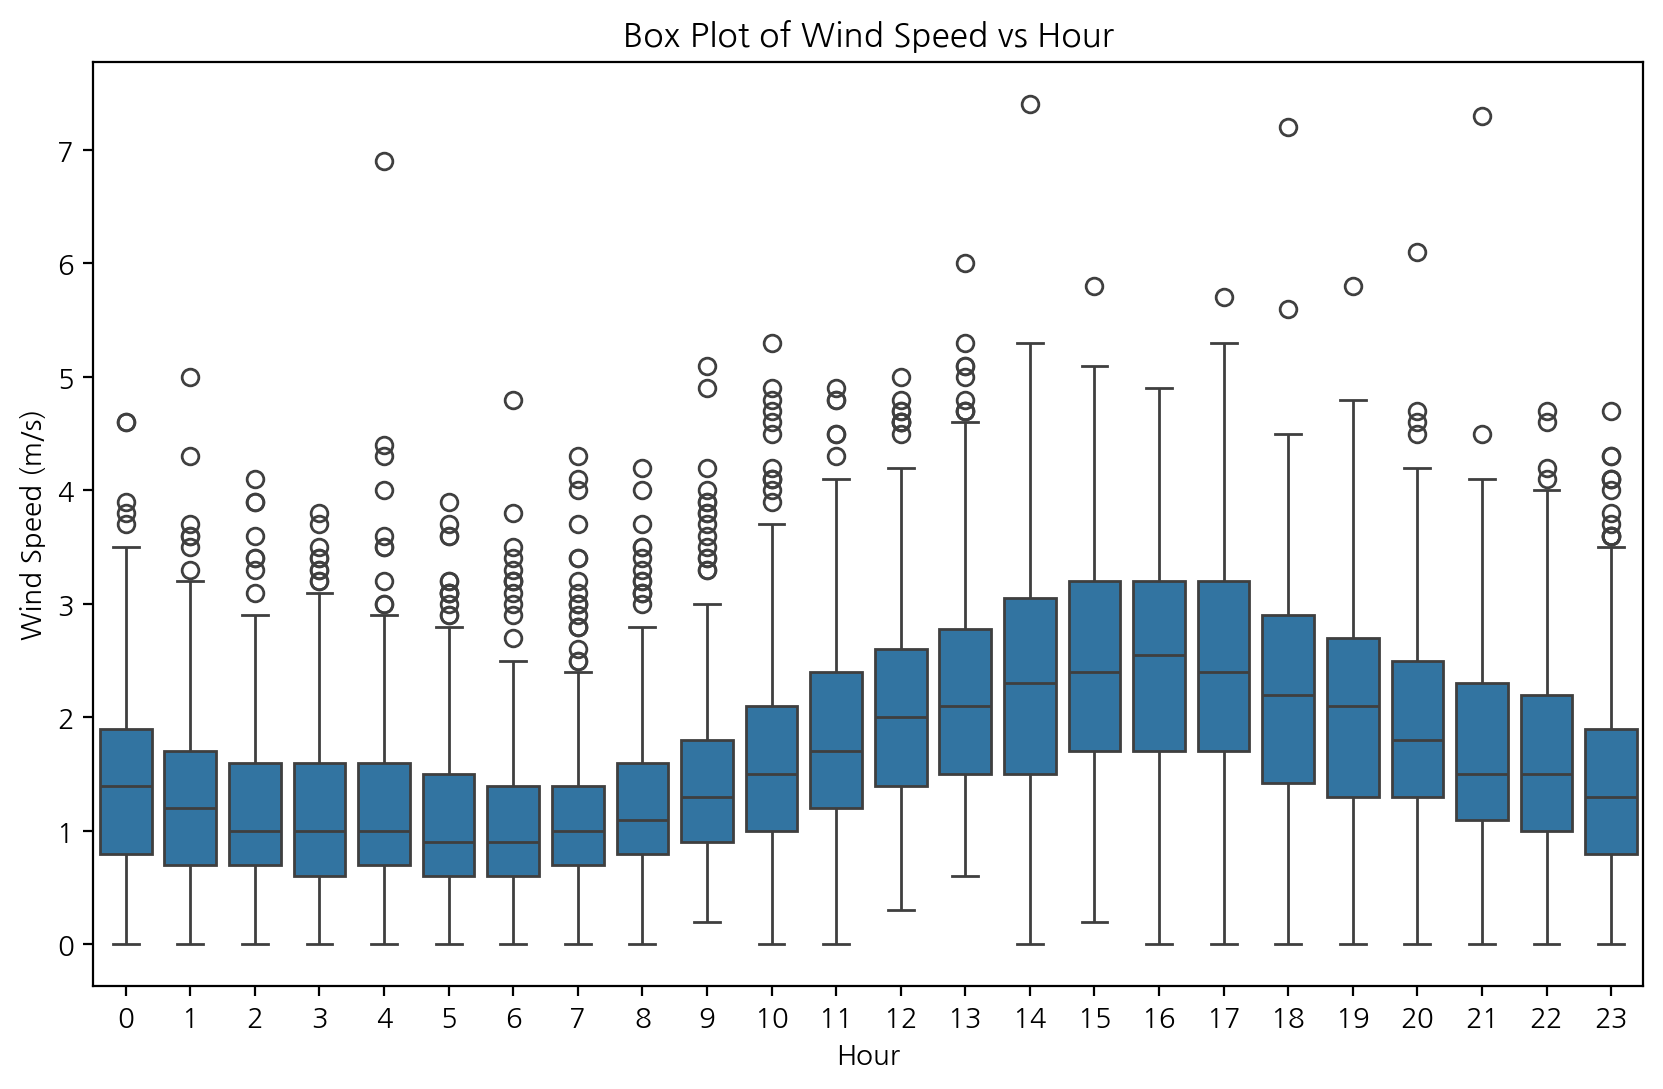

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Hour', y='Wind speed (m/s)', data=df)
plt.title('Box Plot of Wind Speed vs Hour')
plt.xlabel('Hour')
plt.ylabel('Wind Speed (m/s)')
plt.show()

Hour변수와 풍속변수의 박스플롯

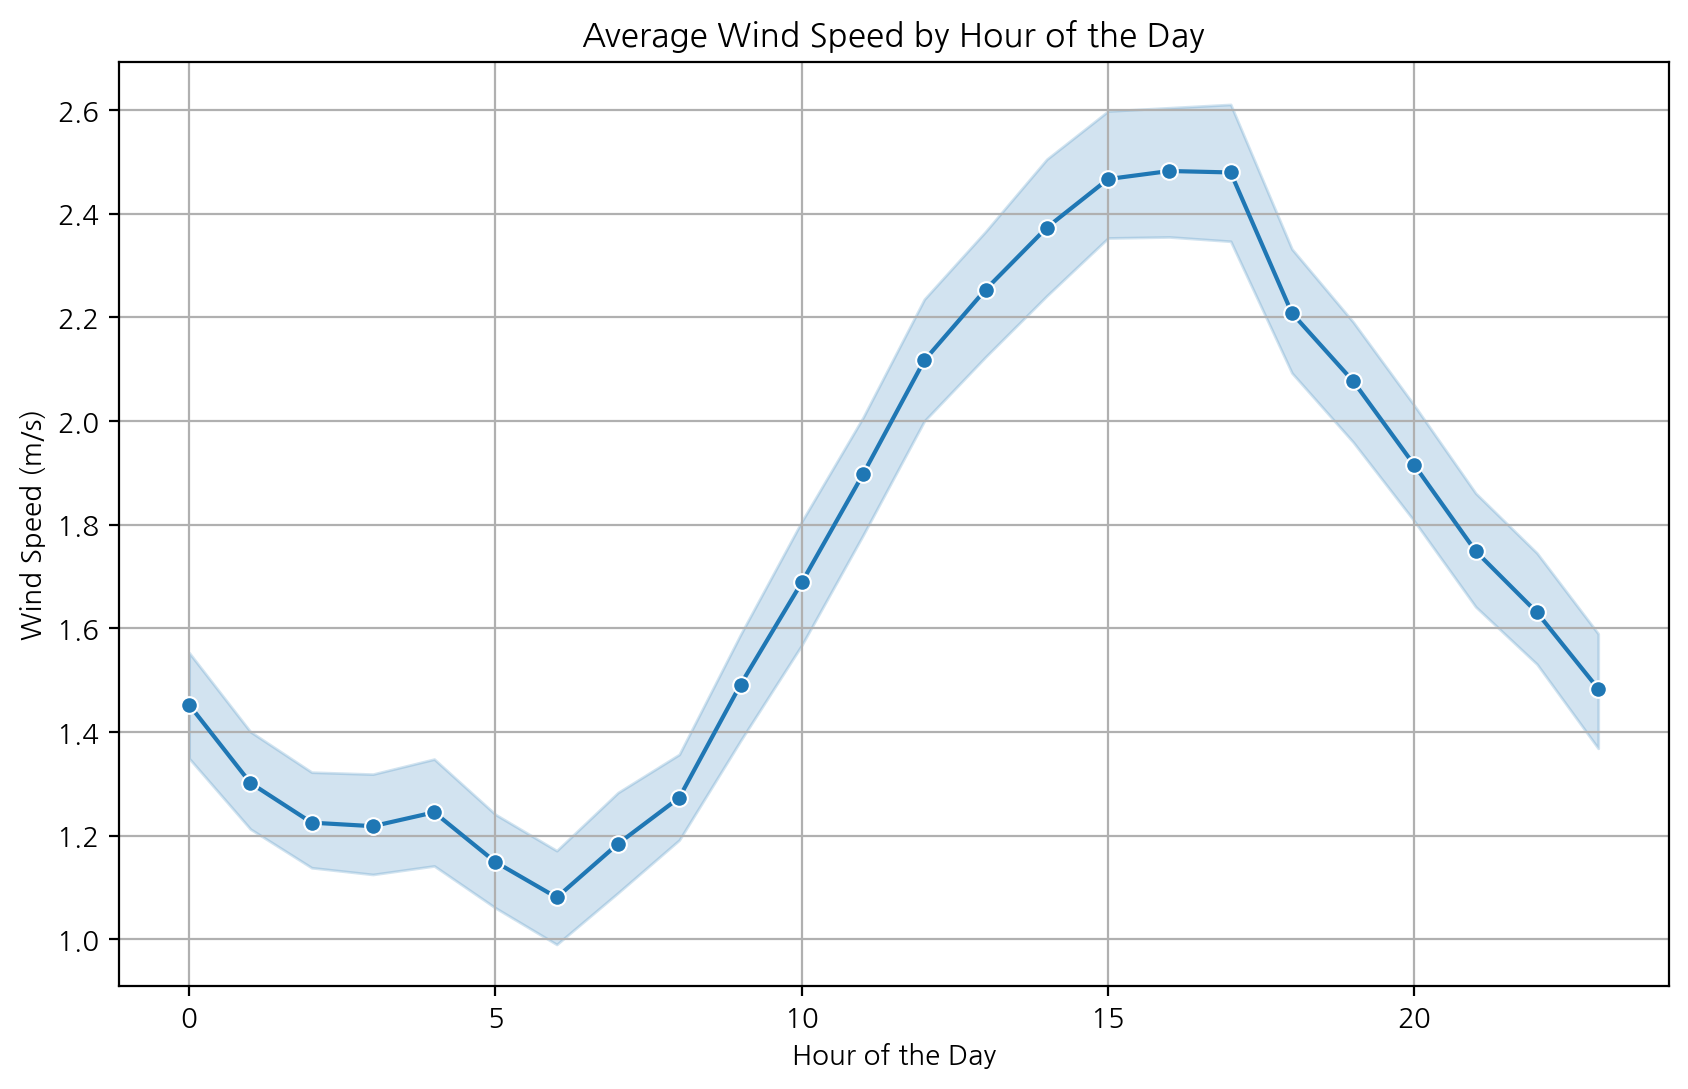

In [12]:
#Hour 변수와 그래프
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Hour', y='Wind speed (m/s)', marker='o')
plt.title('Average Wind Speed by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Wind Speed (m/s)')
plt.grid(True)
plt.show()

Hour변수와 평균 풍속 그래프

결측치를 처리하기 전에 우선 이상치를 확인함. 박스플롯을 보면 눈에 띄는 이상치가 존재하나, 평균 풍속과 Hour변수와의 그래프와 함께 보면 형태가 거의 같음. 

따라서 이상치와 결측치는 스플라인 보간법을 통해 처리함. 이를 통해, 풍속 7(m/s) 근방의 튀는 값들도 큰 영향 없이 부드럽게 보간이 가능함.

In [7]:
df1=df.copy()

#스플라인 보간법
df1['Wind speed (m/s)'] = df1['Wind speed (m/s)'].interpolate(method='spline', order=3)

In [58]:
df1.isna().sum()

Date                           0
Rented Bike Count              0
Hour                           0
Temperature(°C)              702
Humidity(%)                    0
Wind speed (m/s)               0
Visibility (10m)               0
Dew point temperature(°C)      0
Solar Radiation (MJ/m2)        0
Rainfall(mm)                   0
Snowfall (cm)                  0
Seasons                        0
Holiday                        0
Functioning Day                0
dtype: int64

풍속변수의 결측치와 이상치 처리 완료

### 온도변수 결측치 처리
- 계산에 필요한 상대습도, 이슬점 이상치 처리 먼저
- 더 정확한 이슬점 공식 사용

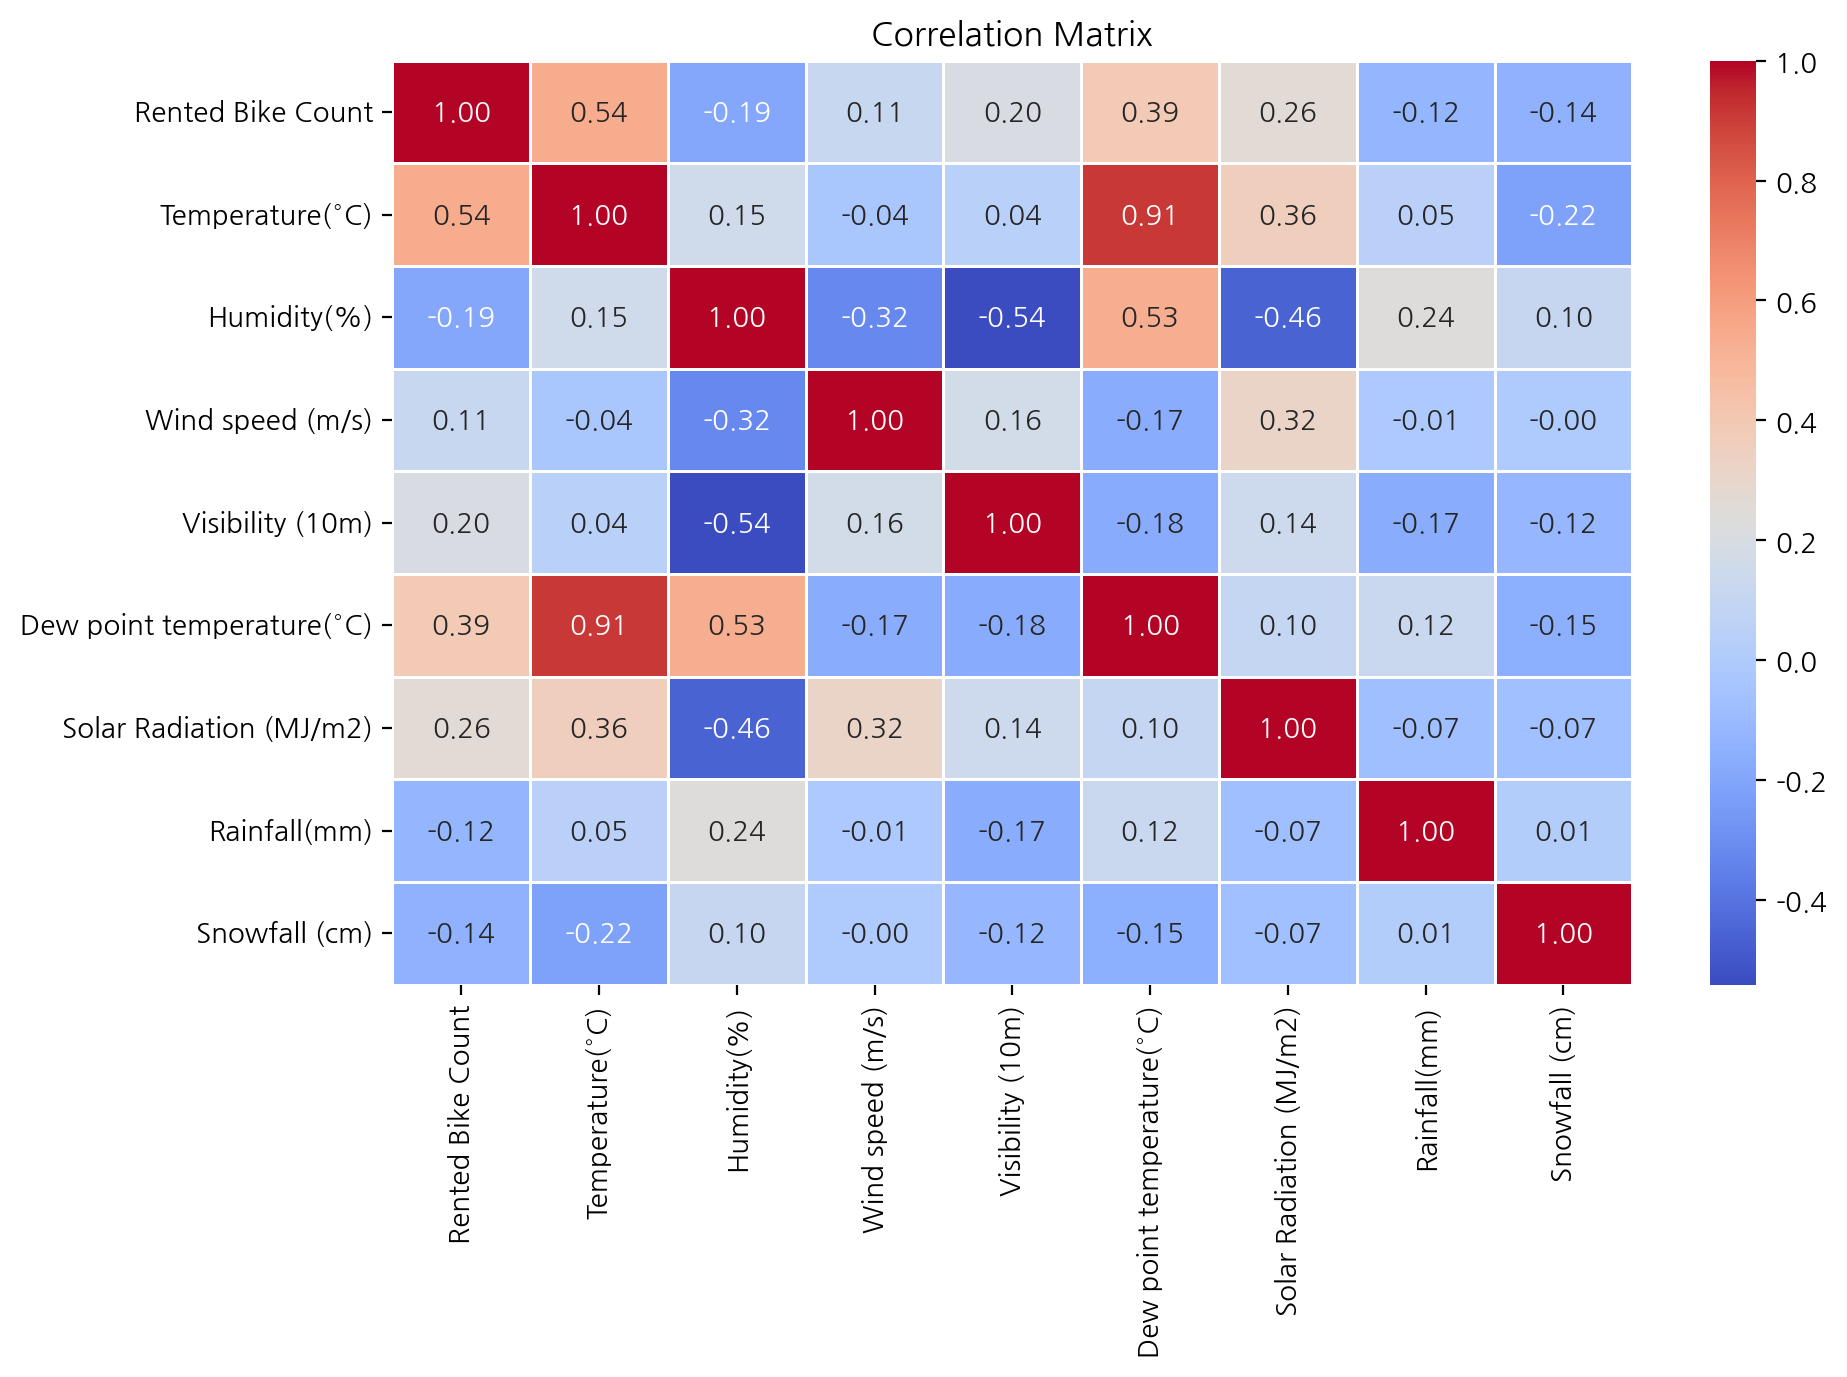

In [25]:
df1_drop=df1.drop(['Date','Hour','Seasons','Holiday','Functioning Day'],axis=1)
corr_matrix = df1_drop.corr()

# 상관관계 행렬을 히트맵으로 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

상관관계를 히트맵으로 시각화 한 결과, 온도는 이슬점과 높은 상관관계(0.91)를 가진다. 이는 이슬점 공식과 관련이 있을 것이다.

이슬점 온도는 'Magnus 공식'을 통해 현재 온도와 상대습도가 있다면 계산이 가능하다. 반대로, 온도 또한 해당 공식으로 결측치를 대체할 수 있다.

**T = t - (100-RH)/5**
- T: 이슬점온도, t: 현재 온도, RH(상대 습도)

오차를 줄이기 위해 이슬점과 상대습도변수를 먼저 살펴본다

### 상대습도 변수 이상치 처리

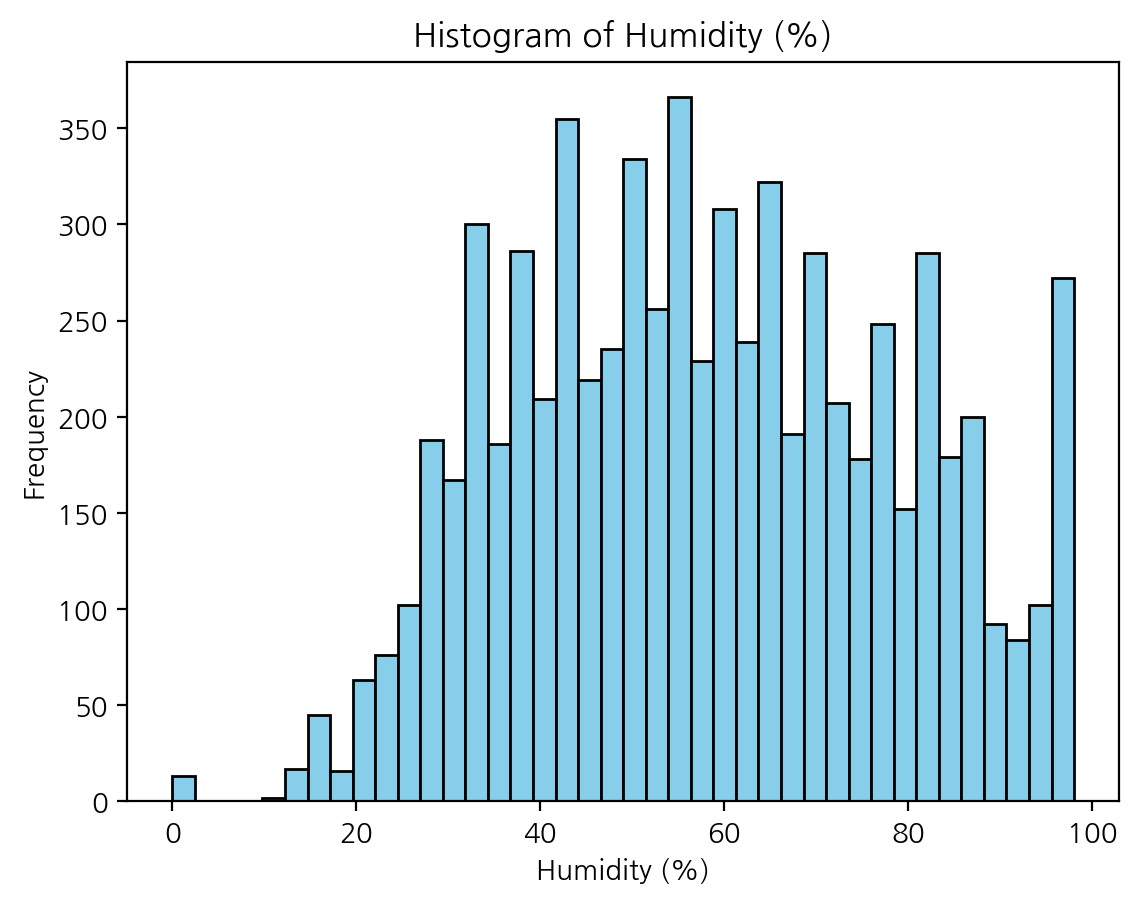

In [29]:
plt.hist(df1['Humidity(%)'], bins=40, color='skyblue', edgecolor='black')
plt.title('Histogram of Humidity (%)')
plt.xlabel('Humidity (%)')
plt.ylabel('Frequency')

plt.show()

상대습도가 0%인 변수들이 존재한다. 상대습도가 0%라는 것은 공기 중에 수증기가 전혀 없음을 의미하는데, 이는 기상학적으로 불가능한 현상이다. 따라서 0을 이상치로 간주하고 처리하겠다

In [45]:
df1[df1['Humidity(%)'] == 0]

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
25,2018-05-28,1502,7,16.8,0,0.80000,1387,8.9,0.36,0.0,0.0,Spring,No Holiday,Yes
273,2018-05-22,248,4,15.6,0,0.50000,1502,10.5,0.00,0.0,0.0,Spring,Holiday,Yes
638,2018-05-21,467,6,11.4,0,0.90000,2000,-2.0,0.03,0.0,0.0,Spring,No Holiday,Yes
1052,2018-05-27,174,5,17.6,0,0.80000,1304,9.7,0.00,0.0,0.0,Spring,No Holiday,Yes
1793,2018-05-22,277,6,15.5,0,0.50000,1691,10.4,0.06,0.0,0.0,Spring,Holiday,Yes
3465,2018-05-28,134,4,17.2,0,0.40000,1619,8.8,0.00,0.0,0.0,Spring,No Holiday,Yes
3764,2018-05-22,406,3,NaN,0,0.70000,1420,10.4,0.00,0.0,0.0,Spring,Holiday,Yes
4296,2018-05-21,200,5,11.9,0,1.30000,2000,-2.7,0.00,0.0,0.0,Spring,No Holiday,Yes
4504,2018-05-21,113,4,12.4,0,0.80000,2000,-3.4,0.00,0.0,0.0,Spring,No Holiday,Yes
5000,2018-05-27,341,7,17.6,0,1.51779,1219,8.7,0.34,0.0,0.0,Spring,No Holiday,Yes


상대습도가 0인 행을 출력해본 결과, 전부 2018년 5월 21일~28일 사이의 관측 데이터임을 알 수 있다. 또한, 전부 오전 10시 이전이다.

우선 처리 방법을 생각하기 위해, 5월 21일 데이터를 추출한다.

In [31]:
df1[(df1['Date'].dt.month == 5) & (df['Date'].dt.day == 21)]

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
150,2018-05-21,2214,17,22.2,45,2.400000,2000,9.6,0.83,0.0,0.0,Spring,No Holiday,Yes
336,2018-05-21,1483,14,23.4,36,2.800000,1947,7.4,3.11,0.0,0.0,Spring,No Holiday,Yes
638,2018-05-21,467,6,11.4,0,0.900000,2000,-2.0,0.03,0.0,0.0,Spring,No Holiday,Yes
1835,2018-05-21,1118,9,17.7,27,1.300000,2000,-1.5,2.02,0.0,0.0,Spring,No Holiday,Yes
1837,2018-05-21,1129,11,20.9,27,1.700000,2000,1.1,3.11,0.0,0.0,Spring,No Holiday,Yes
3011,2018-05-21,666,0,15.3,29,1.300000,2000,-2.6,0.00,0.0,0.0,Spring,No Holiday,Yes
3330,2018-05-21,420,1,NaN,31,1.100000,2000,-2.4,0.00,0.0,0.0,Spring,No Holiday,Yes
3365,2018-05-21,1373,12,21.8,31,2.100000,2000,3.9,3.39,0.0,0.0,Spring,No Holiday,Yes
3467,2018-05-21,1612,15,23.3,38,1.500000,1963,8.1,2.13,0.0,0.0,Spring,No Holiday,Yes
4263,2018-05-21,1785,8,15.3,30,1.300000,2000,-2.2,1.30,0.0,0.0,Spring,No Holiday,Yes


21일의 상대습도는 27% ~ 70% 사이로 분포하며, 이는 Hour변수와 관련이 있어보인다. 더 자세하게 살펴보기 위해 21일~28일까지만 필터링해, Hour변수와 상대습도변수 사이의 바 플롯을 그려보겠다.

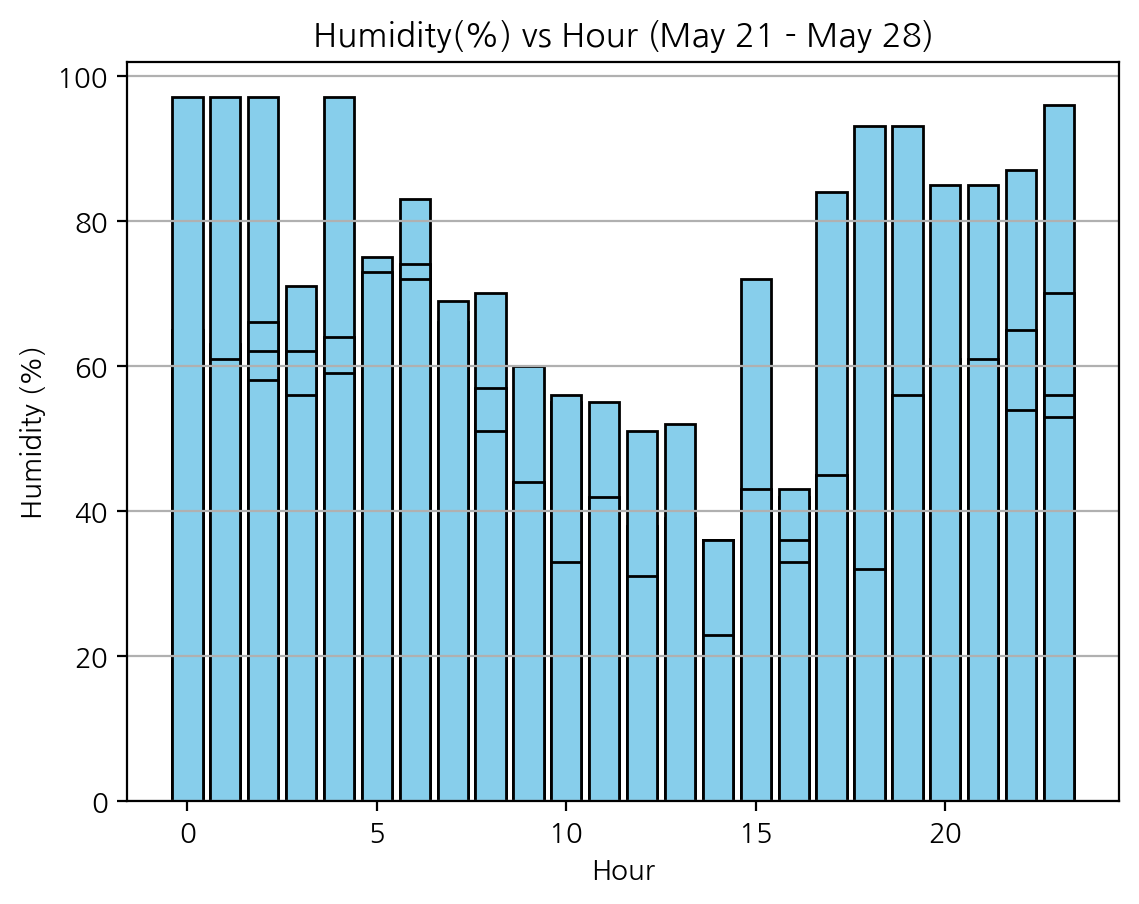

In [8]:
filtered_df = df1[(df1['Date'] >= '2018-05-21') & (df1['Date'] <= '2018-05-28')] 
#2018년 5월 21일 ~ 28일까지만 필터링a

# 바 플롯
plt.bar(filtered_df['Hour'], filtered_df['Humidity(%)'], color='skyblue', edgecolor='black')

plt.title('Humidity(%) vs Hour (May 21 - May 28)')
plt.xlabel('Hour')
plt.ylabel('Humidity (%)')

plt.grid(axis='y')  # y축에 그리드 추가
plt.show()

예상했던 대로, 상대습도는 Hour변수와 상관관계가 있다. 따라서, 전부 오전 10시 이전의 관측치였던 상대습도의 이상치는 3시에서 7시 사이 상대습도의 평균값으로 대체한다.

In [9]:
# 21일~ 28일 사이의 Hour 변수가 3에서 7 사이인 데이터들만 필터링하고, Humidity(%) 값이 0이 아닌 데이터만 선택
filtered_hour_df = filtered_df[(filtered_df['Hour'] >= 3) & (filtered_df['Hour'] <= 7) & (filtered_df['Humidity(%)'] != 0)]

# 평균 상대습도 값을 계산
average_h = filtered_hour_df['Humidity(%)'].mean()

df2=df1.copy()
# Humidity(%) 값이 0인 데이터에 평균값을 대입
df2.loc[(df2['Humidity(%)'] == 0), 'Humidity(%)'] = average_h

In [10]:
df2[df2['Humidity(%)']==0]

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day


이상치가 잘 매꿔졌다. 이제 이슬점변수를 탐색한다.

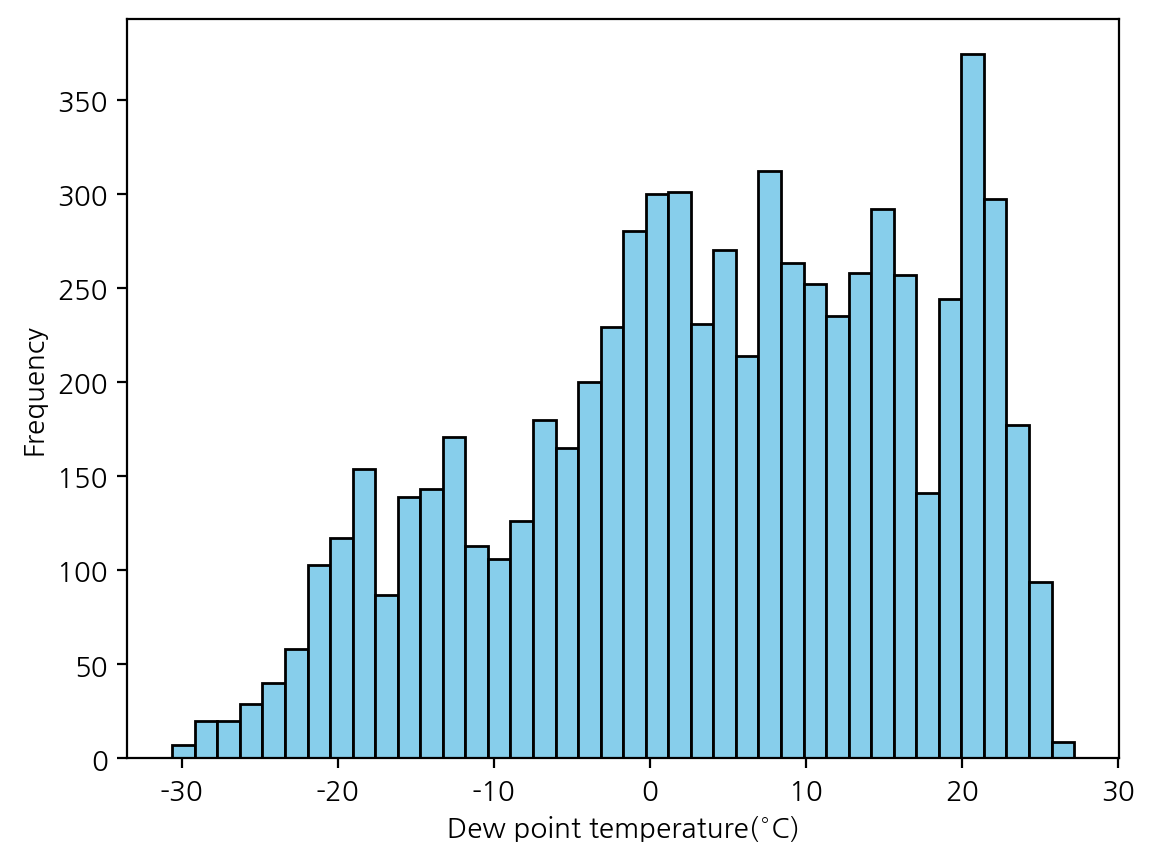

In [11]:
plt.hist(df2['Dew point temperature(°C)'], bins=40, color='skyblue', edgecolor='black')
plt.xlabel('Dew point temperature(°C)')
plt.ylabel('Frequency')

plt.show()

눈에 띄는 이상치는 확인되지 않는다. 이제 근사값 공식을 사용해 온도변수의 결측치를 채우겠다.

In [12]:
df3=df2.copy()

df3['Temperature(°C)'] = df3.apply(
    lambda row: row['Dew point temperature(°C)'] + (100 - row['Humidity(%)']) / 5 
    if pd.isnull(row['Temperature(°C)']) else row['Temperature(°C)'], axis=1
)

df3.isna().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

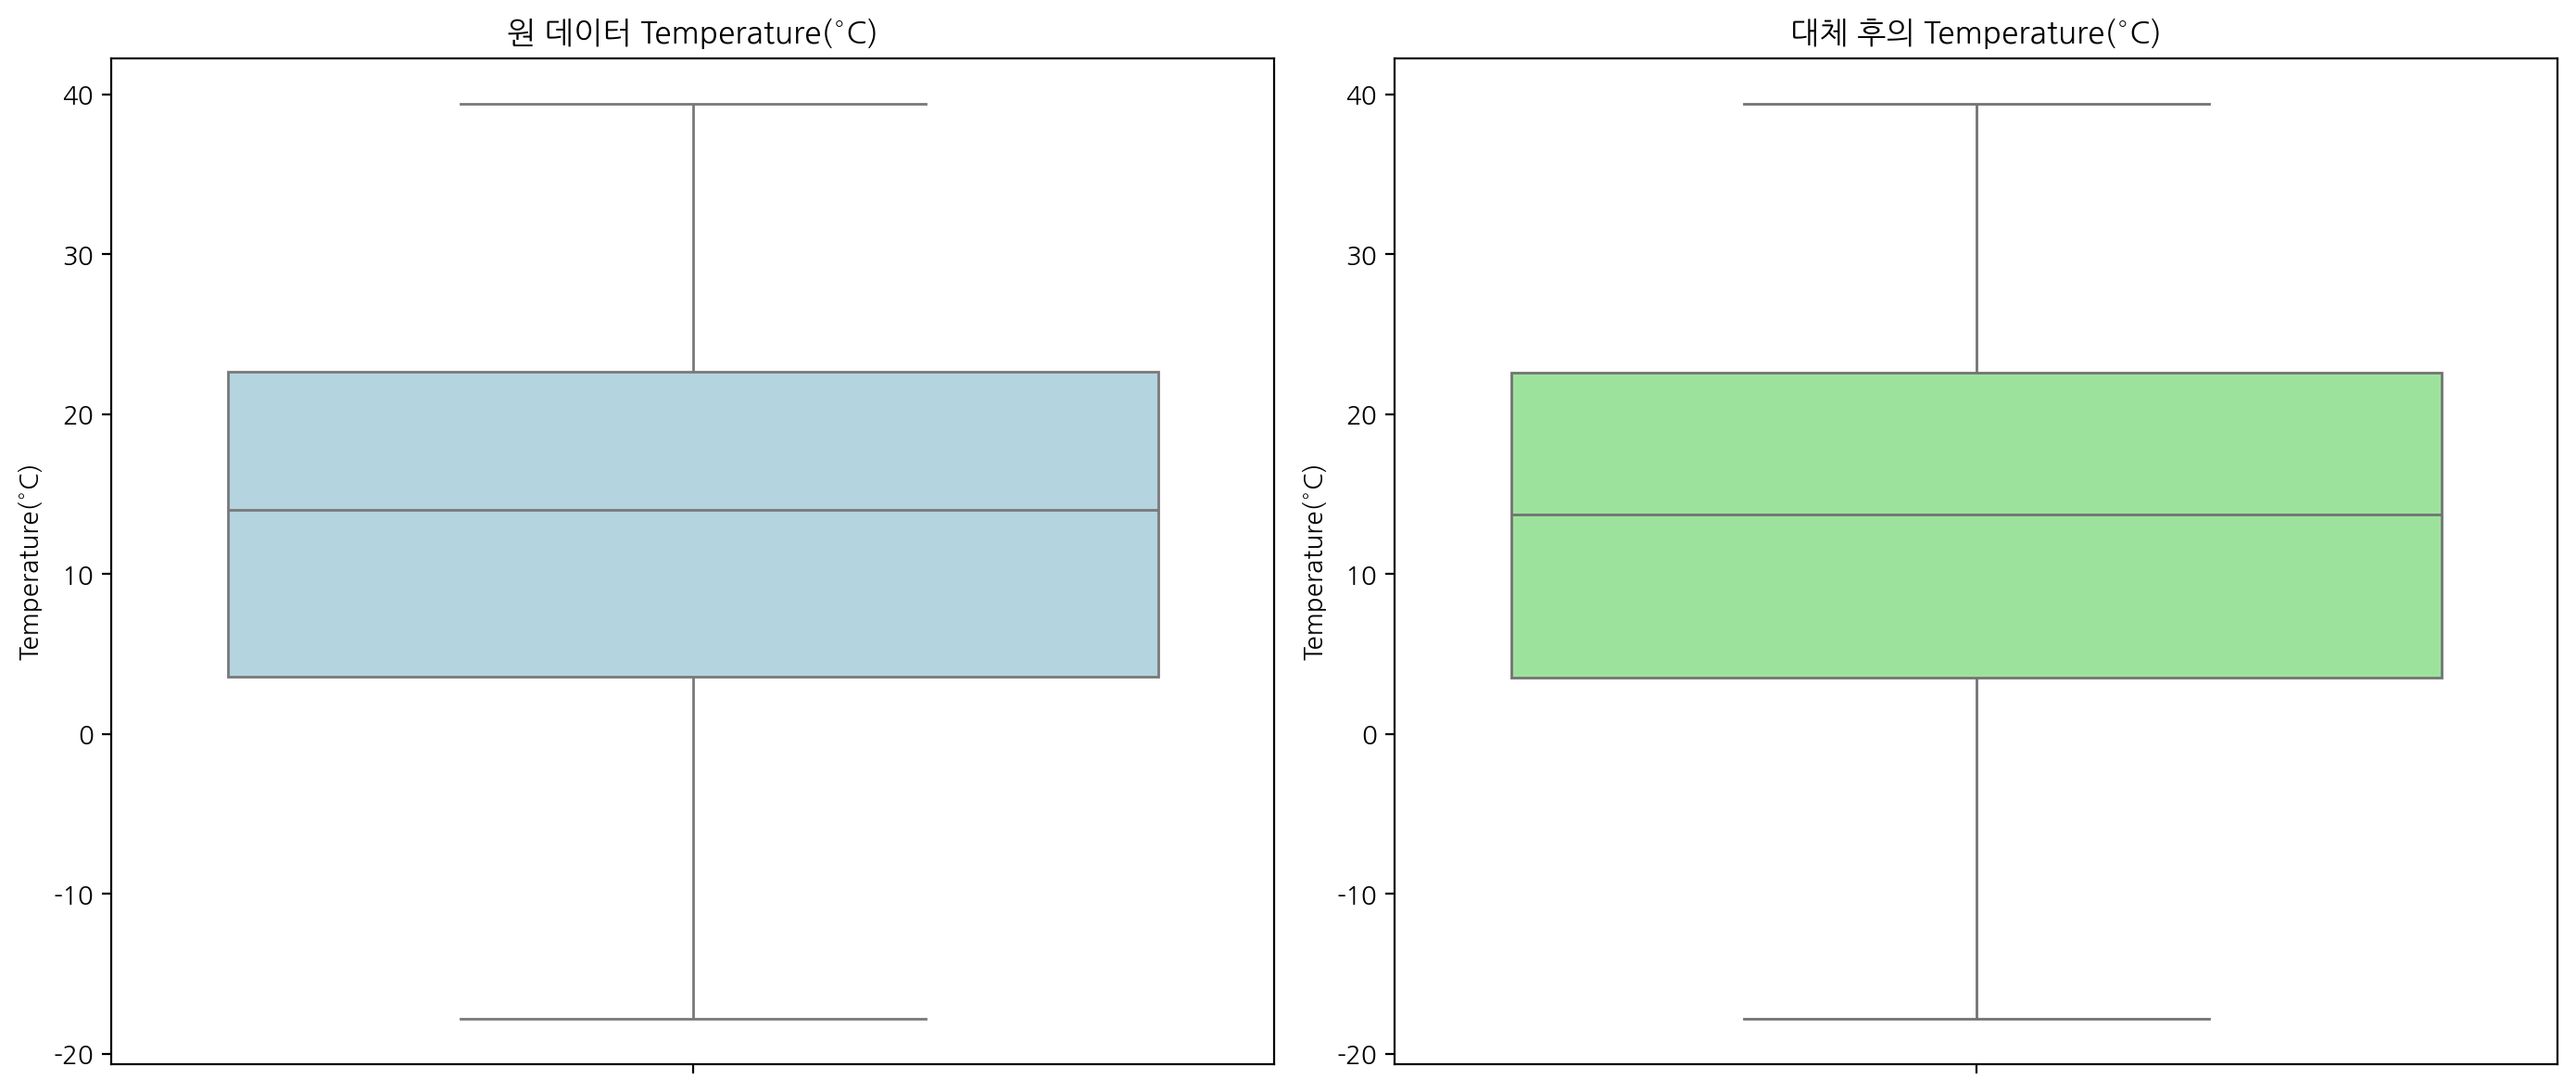

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.boxplot(df['Temperature(°C)'],color='lightblue',ax=axs[0])
axs[0].set_title('원 데이터 Temperature(°C)')
axs[0].set_ylabel('Temperature(°C)')

sns.boxplot(y=df3['Temperature(°C)'], color='lightgreen', ax=axs[1])
axs[1].set_title('대체 후의 Temperature(°C)')
axs[1].set_ylabel('Temperature(°C)')

plt.tight_layout()
plt.show()

원 데이터와 비교해서 봤을 때, 이상치 없이 결측치는 잘 매꿔졌다. 

### Rented Bike Count 변수
- 이상치X

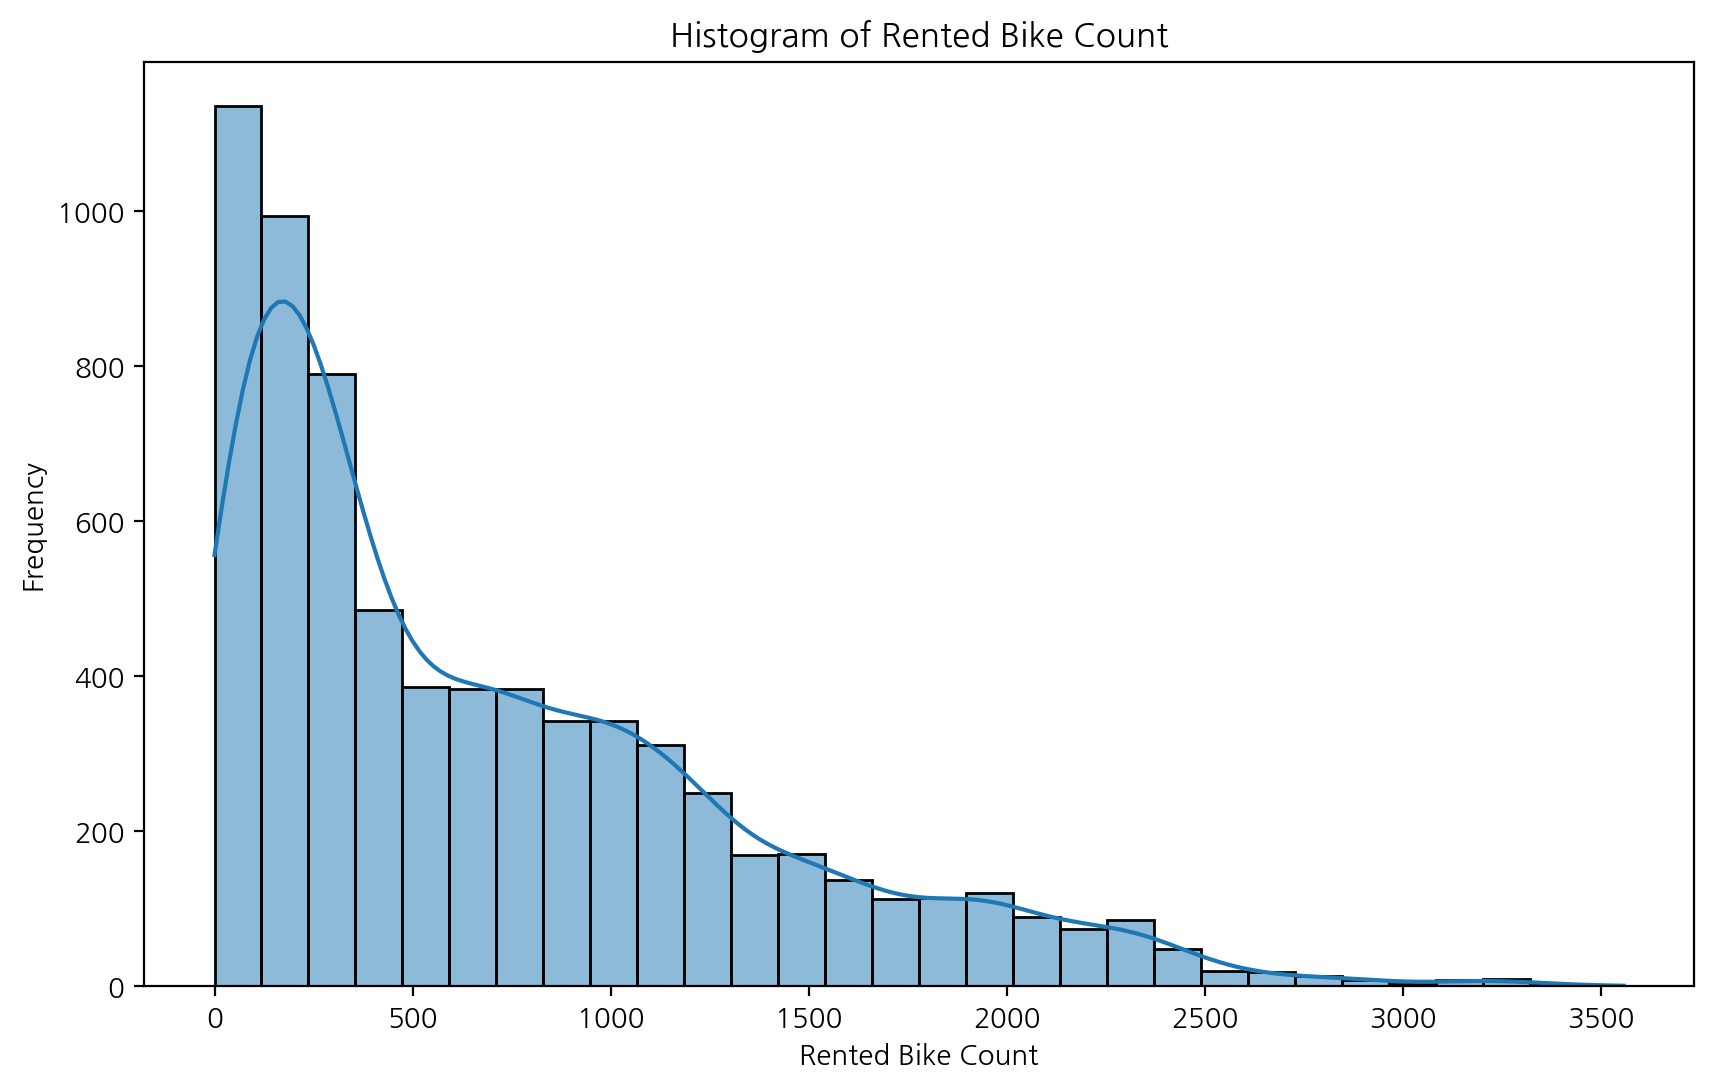

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(df3['Rented Bike Count'], bins=30, kde=True)
plt.title('Histogram of Rented Bike Count')
plt.xlabel('Rented Bike Count')
plt.ylabel('Frequency')
plt.show()

이상치는 없음. 

### Hour 변수
- 시간대별 자전거 대여 빈도수는 거의 비슷하나, 대여량 자체는 출근시간과 퇴근시간이 많음

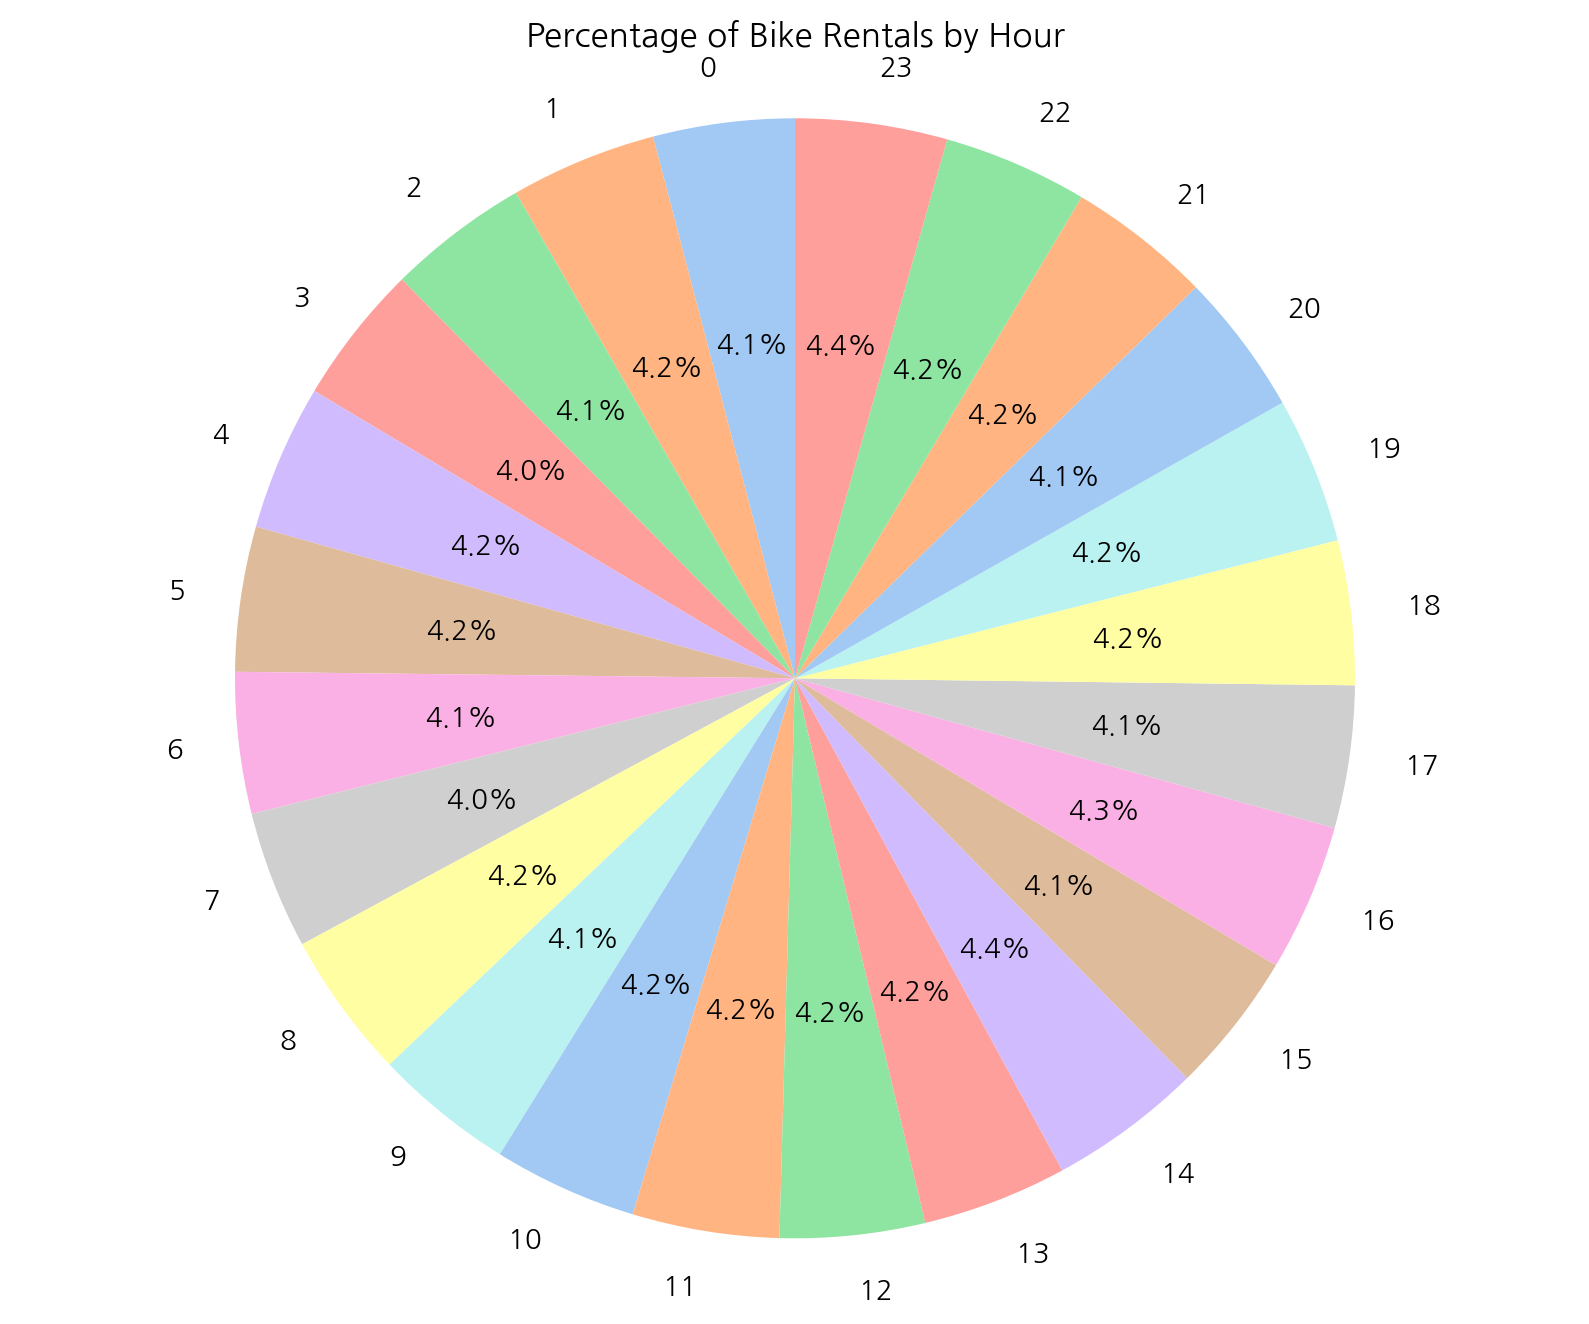

In [16]:
# 시간대별 자전거 대여 수 집계
hourly_counts = df3.groupby('Hour').size()

colors = sns.color_palette('pastel', len(hourly_counts))

# 원그래프 그리기
plt.figure(figsize=(10, 8))
plt.pie(hourly_counts, labels=hourly_counts.index, autopct='%1.1f%%', startangle=90,colors=colors)
plt.title('Percentage of Bike Rentals by Hour')
plt.axis('equal')  
plt.show()

빈도 거의 비슷

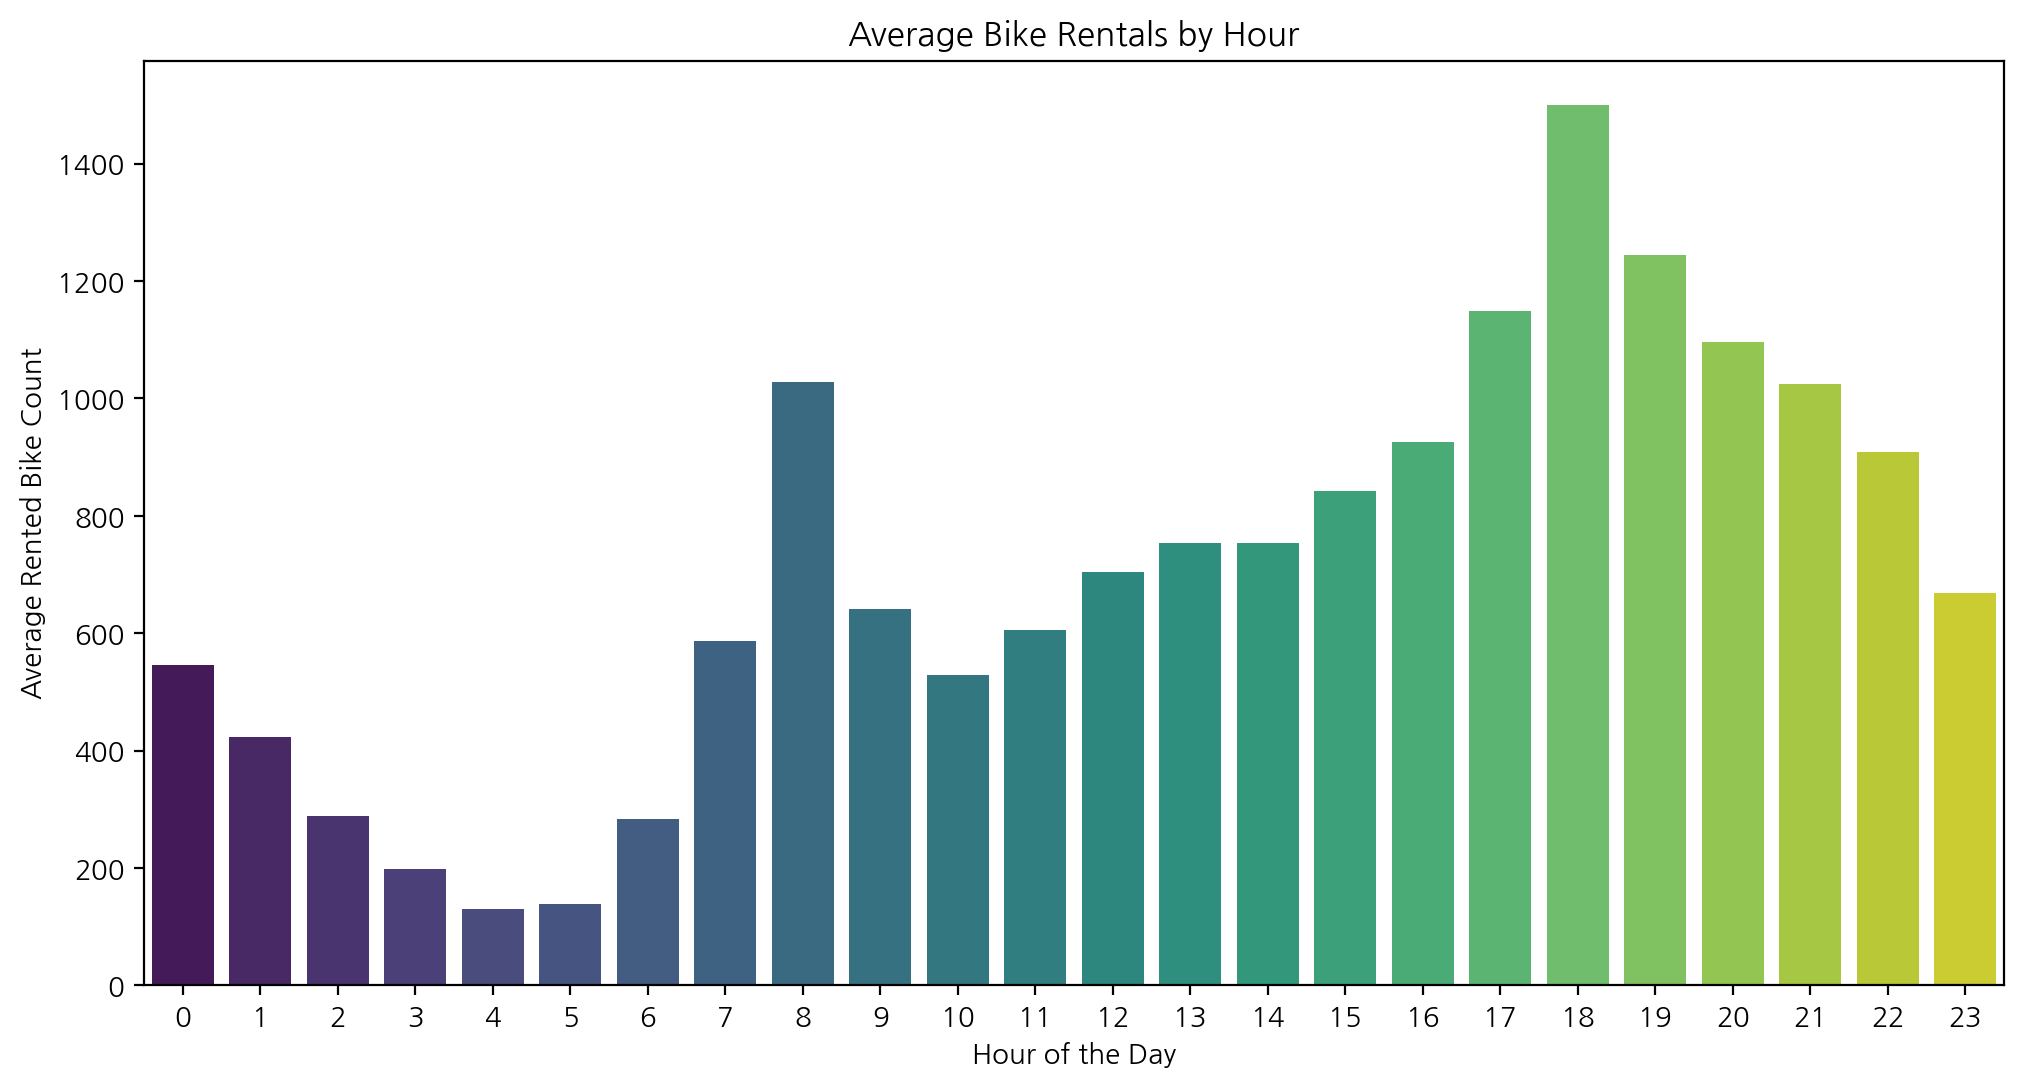

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Hour', y='Rented Bike Count', data=df3, ci=None, palette='viridis')
plt.title('Average Bike Rentals by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Rented Bike Count')
plt.xticks(range(0, 24))
plt.show()

대여량은 출근시간(7시)과 퇴근시간(18시)에 눈에 띄게 많음. 이상치X

### Visibility (10m) 변수
- 이상치X

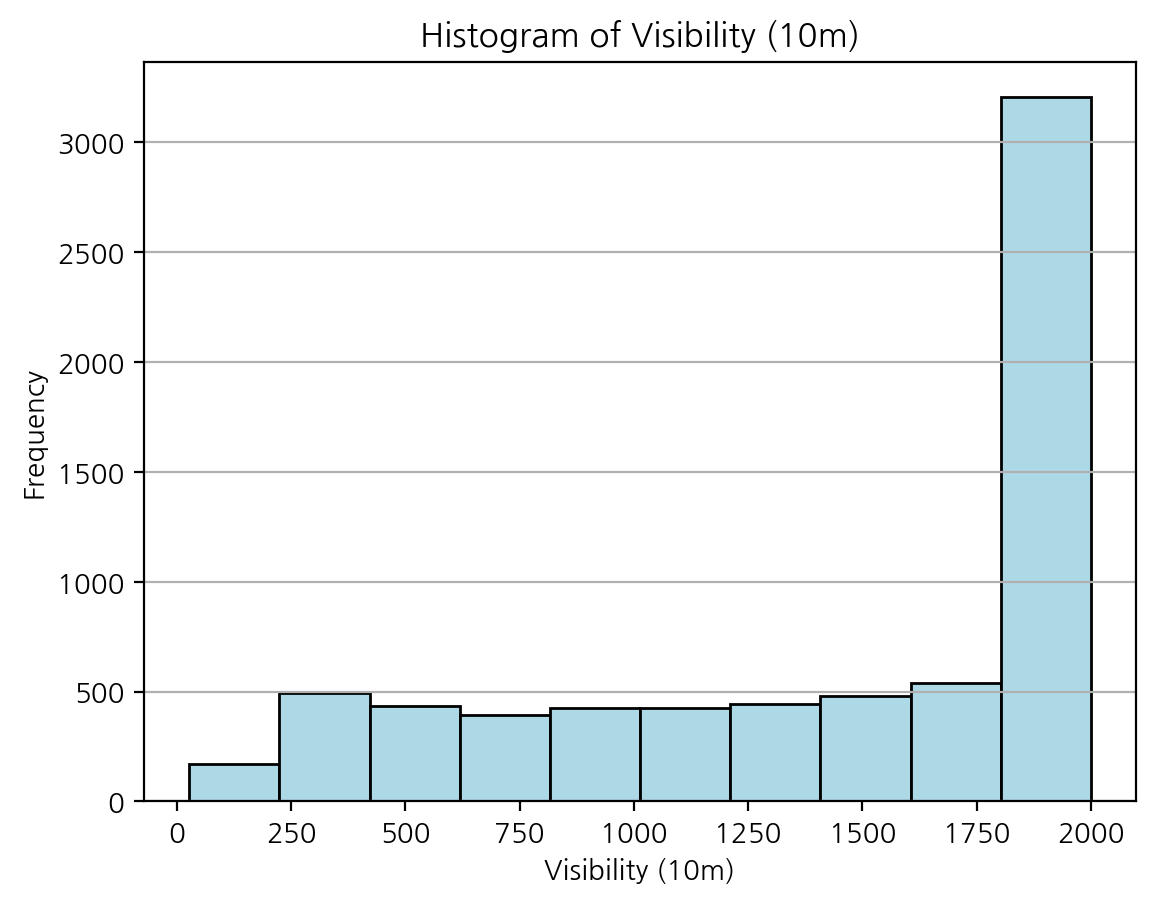

In [21]:
plt.hist(df3['Visibility (10m)'], bins=10, color='lightblue', edgecolor='black')
plt.title('Histogram of Visibility (10m)')
plt.xlabel('Visibility (10m)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

눈에 띄는 이상치X

### Dew point temperature(°C)
- 이상치X

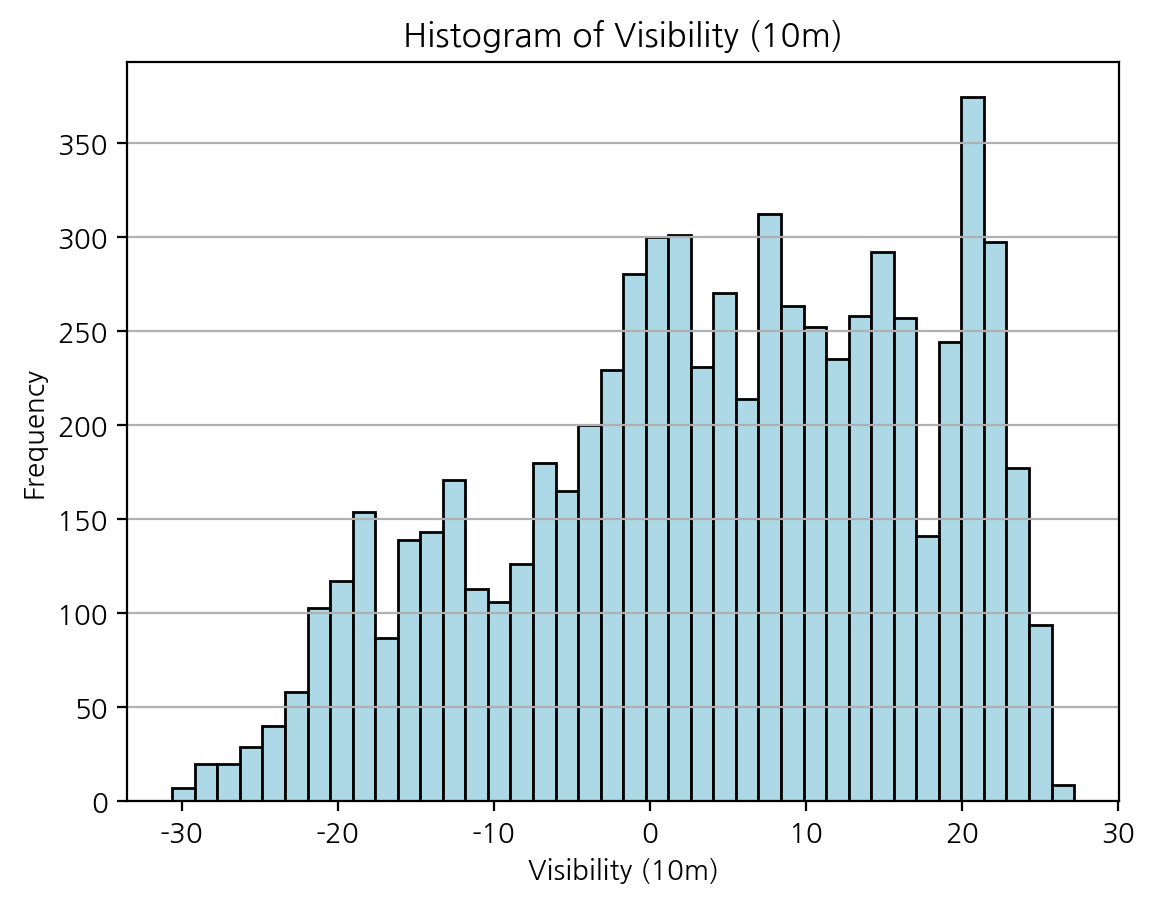

In [23]:
plt.hist(df3['Dew point temperature(°C)'], bins=40, color='lightblue', edgecolor='black')
plt.title('Histogram of Visibility (10m)')
plt.xlabel('Visibility (10m)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

<Axes: ylabel='Dew point temperature(°C)'>

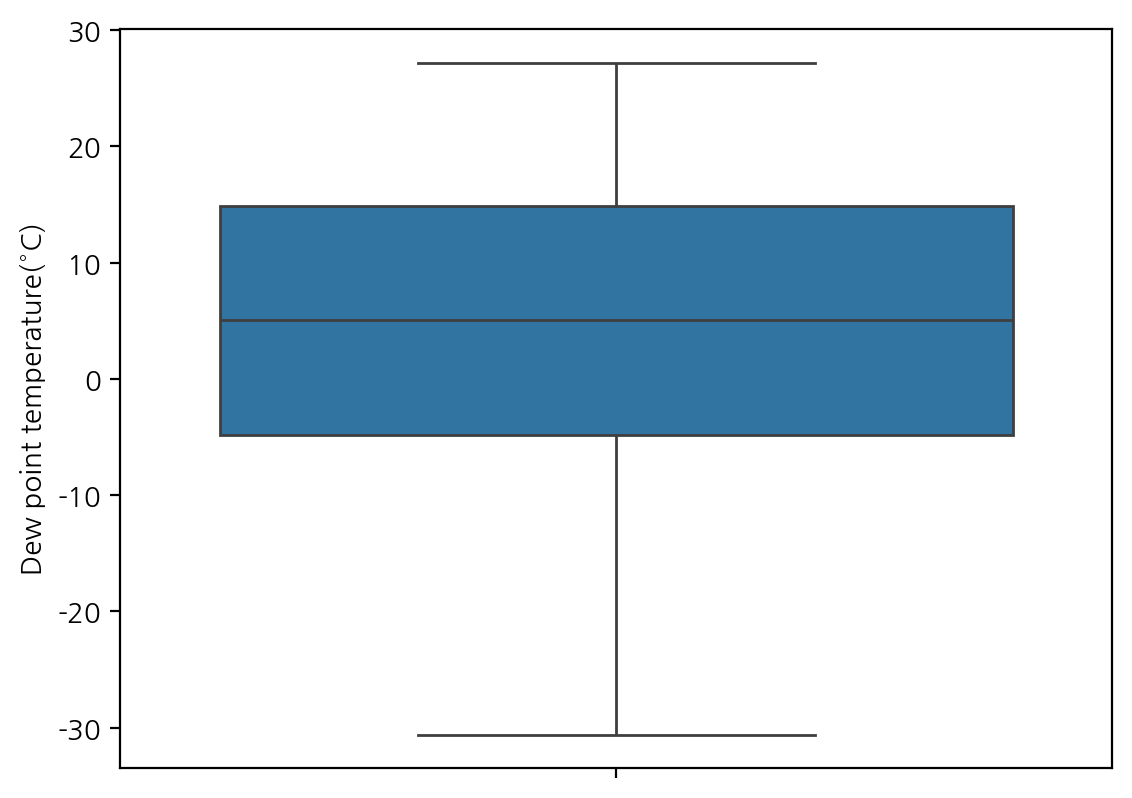

In [24]:
sns.boxplot(df3['Dew point temperature(°C)'])

이상치 보이지 않음

### Solar Radiation (MJ/m2)
- 이상치X

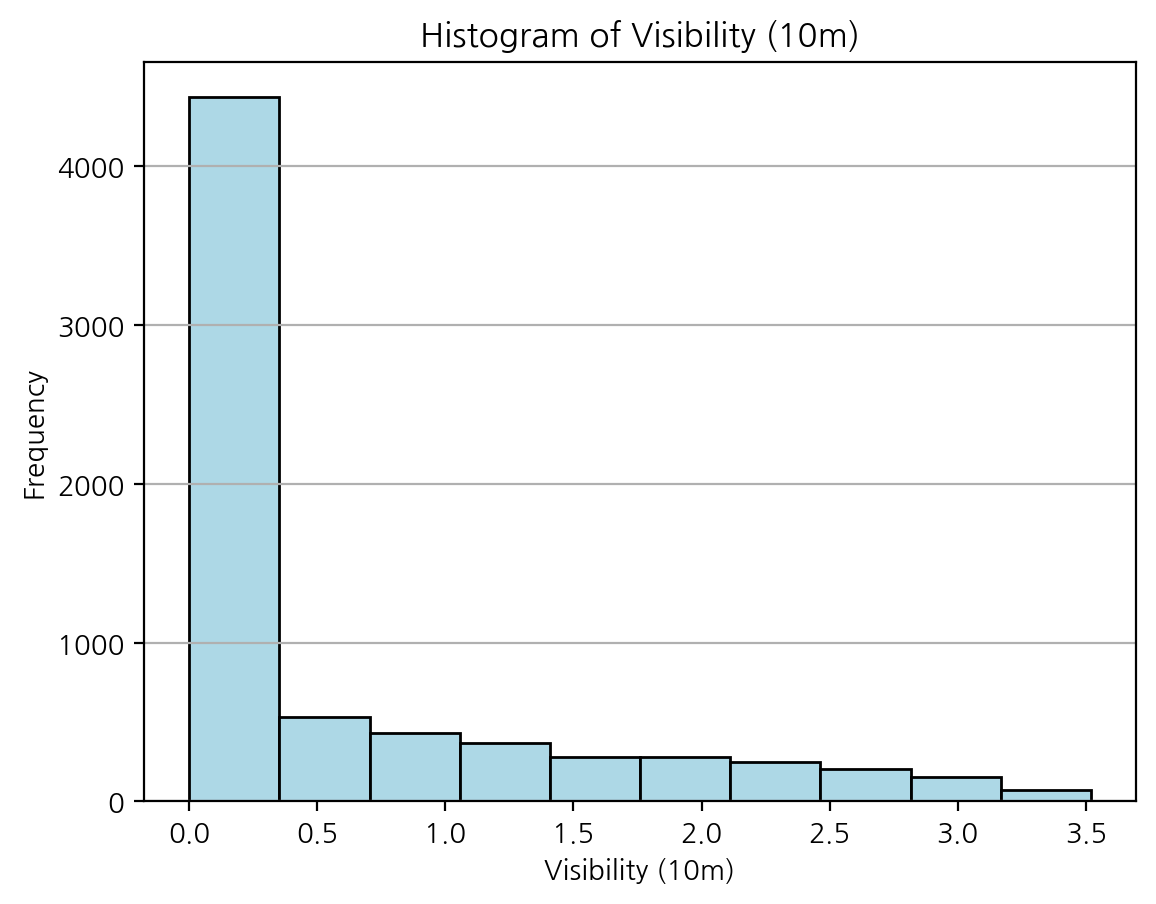

In [28]:
plt.hist(df3['Solar Radiation (MJ/m2)'], bins=10, color='lightblue', edgecolor='black')
plt.title('Histogram of Visibility (10m)')
plt.xlabel('Visibility (10m)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

0부근에 몰려있음

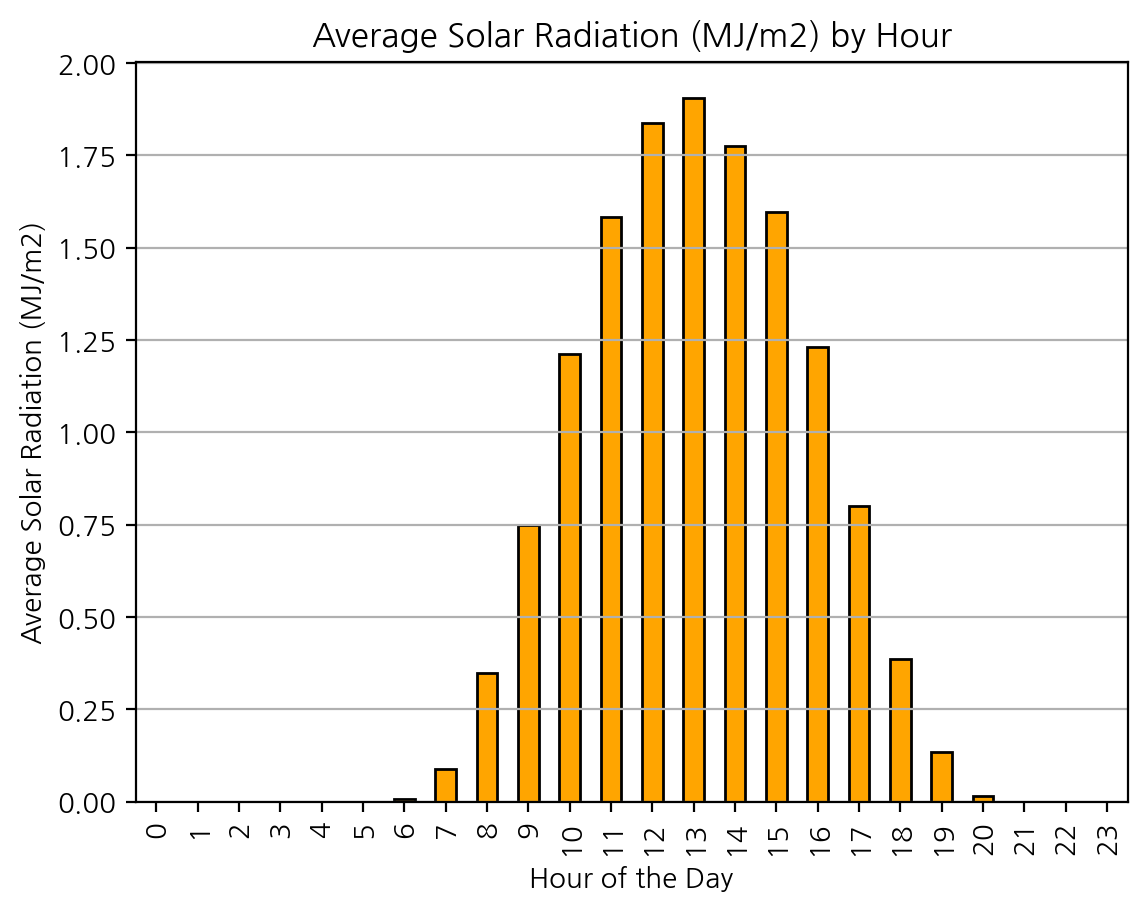

In [29]:
hourly_solar_radiation = df3.groupby('Hour')['Solar Radiation (MJ/m2)'].mean()

hourly_solar_radiation.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Average Solar Radiation (MJ/m2) by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Solar Radiation (MJ/m2)')
plt.grid(axis='y')
plt.show()

튀는 부분 없이 데이터는 잘 분포되어 있음. 태양복사량은 날이 흐리거나 밤이 되면 0에 가까워지는게 당연하므로, 이상치는 아님.

### Rainfall(mm), Snowfall (cm) 변수
- 파생변수 생성

### 파생변수 생성
- 강수량, 강설량은 빈도가 낮기 때문에, 모델의 성능을 위해 내림(1)과 내리지 않음(0)인 파생변수를 추가

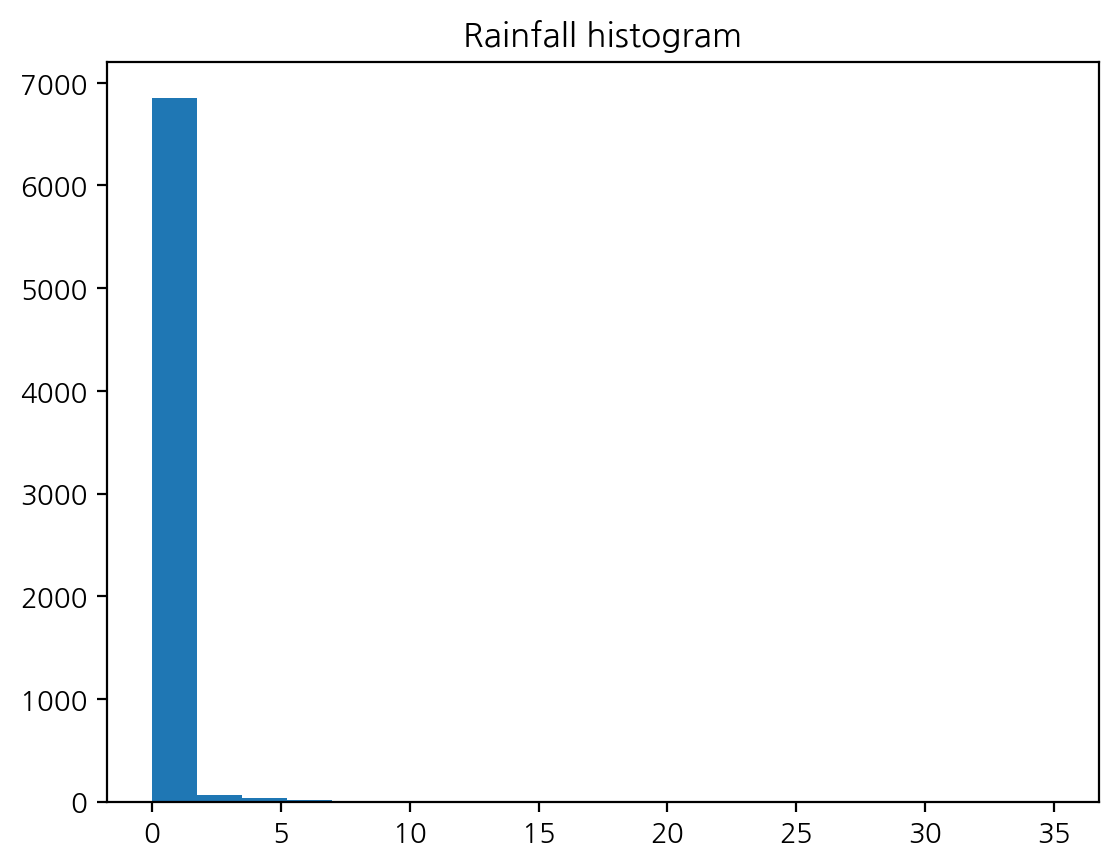

In [34]:
plt.hist(df3['Rainfall(mm)'],bins=20)
plt.title('Rainfall histogram',fontsize=12)
plt.show()

In [9]:
#비 X
rainfall_x = (df3['Rainfall(mm)'] == 0).sum()

# 비 O
rainfall_o = (df3['Rainfall(mm)'] > 0).sum()

print(f"비 안온 날 : {rainfall_x}개")
print(f"비 온 날 : {rainfall_o}개")

비 안온 날 : 6588개
비 온 날 : 420개


비가 온 날보다 오지 않은 날이 대부분임.

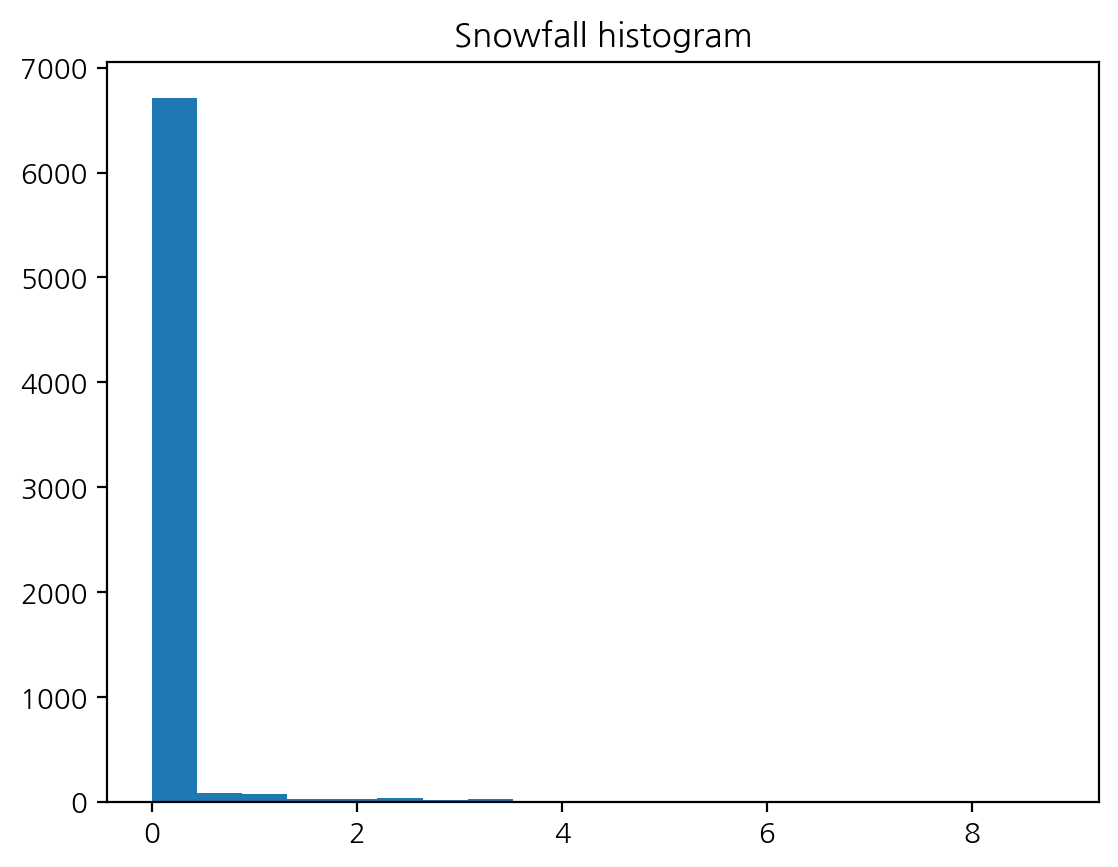

In [38]:
plt.hist(df3['Snowfall (cm)'],bins=20)
plt.title('Snowfall histogram',fontsize=12)
plt.show()

In [33]:
#눈 X
snow_x = (df3['Snowfall (cm)'] == 0).sum()

# 눈 O
snow_o = (df3['Snowfall (cm)'] > 0).sum()

print(f"비 안온 날 : {snow_x}개")
print(f"비 온 날 : {snow_o}개")

비 안온 날 : 6652개
비 온 날 : 356개


Snowfall 변수도 비슷한 상황이다. 두 데이터는 모두 오지 않은 날이 대부분이므로, 내림(1) 내리지 않음(0)으로 분류하는 새로운 파생변수 Rain, Snow를 각각 생성한다.

In [13]:
# Rain변수 생성
df3['Rain'] = df3['Rainfall(mm)'].apply(lambda x: 0 if x == 0 else 1)
# Snow 변수 생성
df3['Snow'] = df3['Snowfall (cm)'].apply(lambda x: 0 if x == 0 else 1)

### Seasons 변수

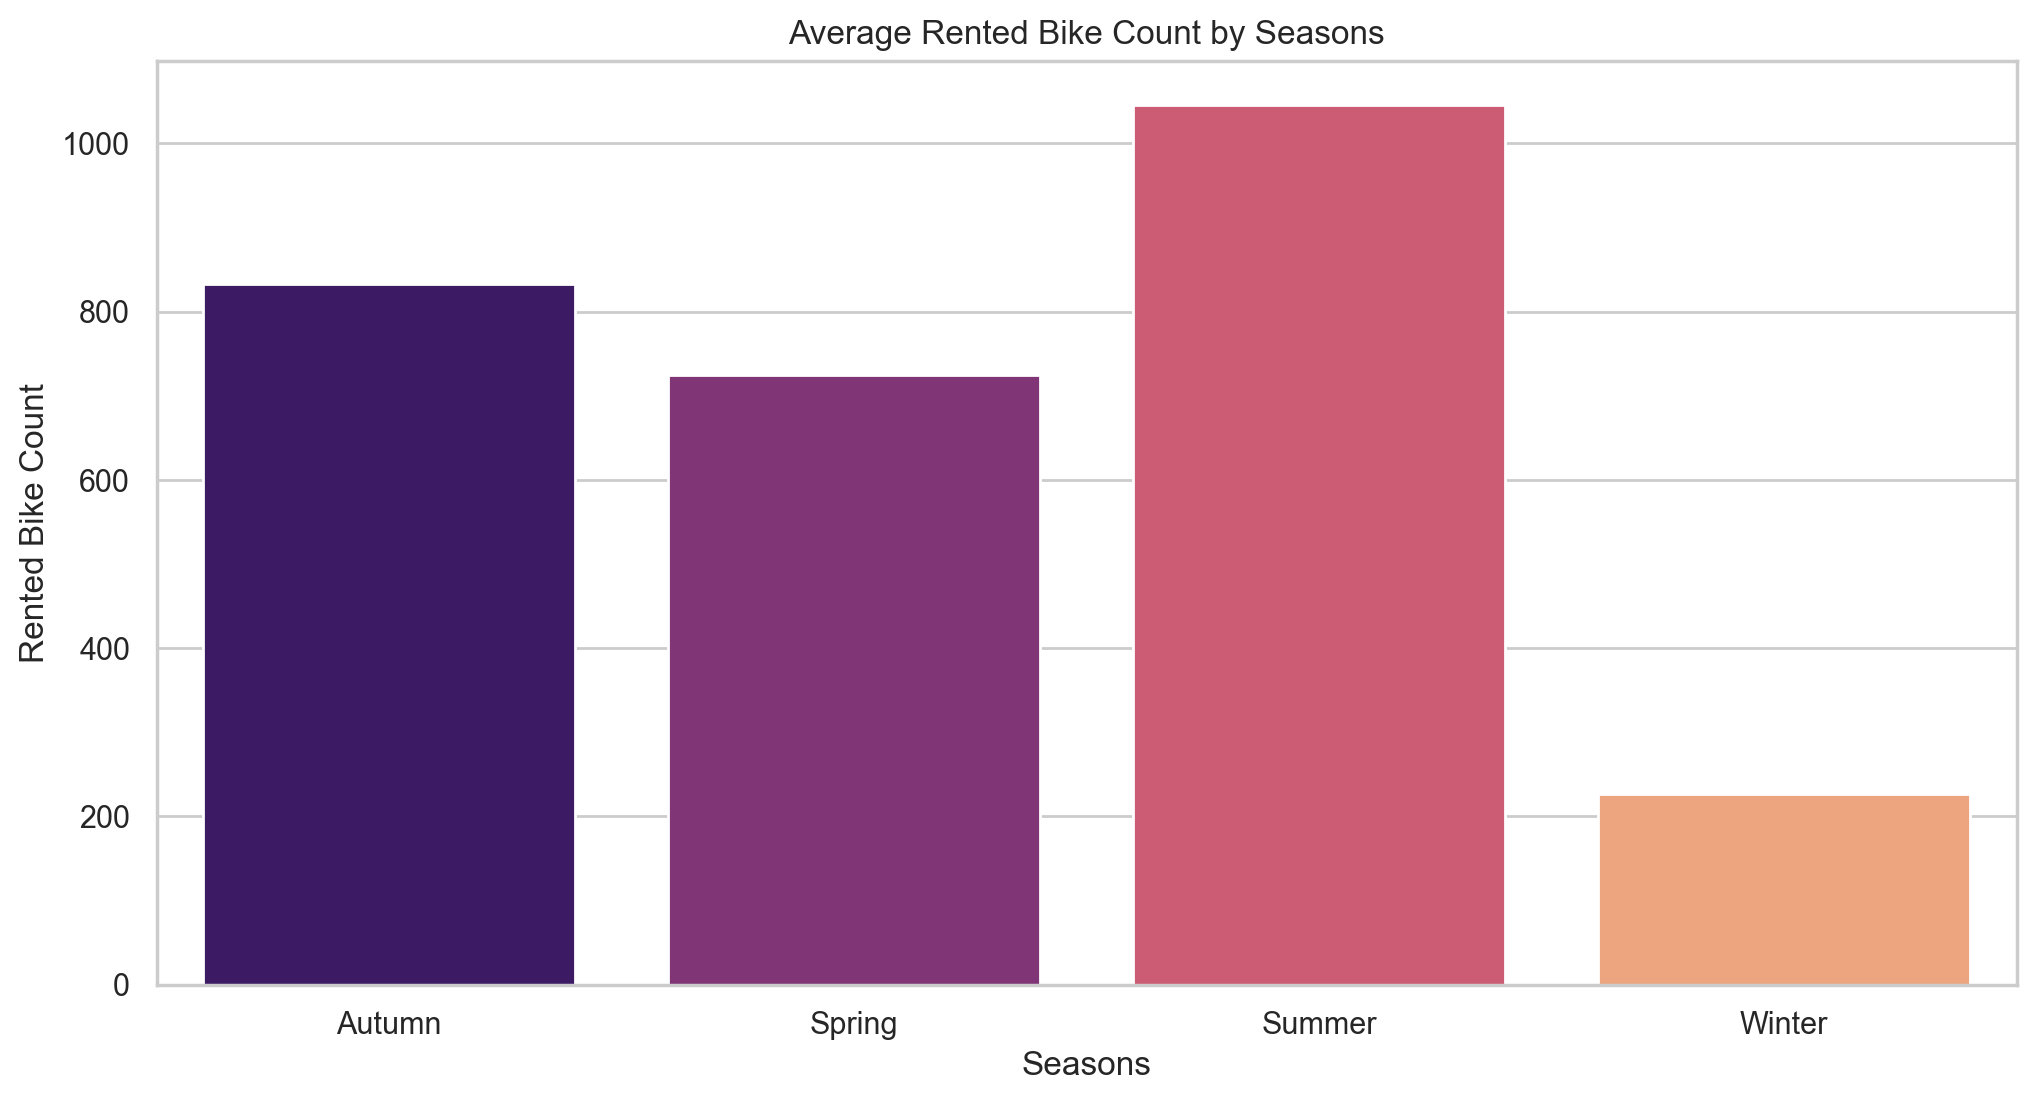

In [41]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# 계절별 자전거 대여 횟수 평균 시각화
seasonal_avg = df3.groupby('Seasons')['Rented Bike Count'].mean().reset_index()
sns.barplot(x='Seasons', y='Rented Bike Count', data=seasonal_avg, palette='magma')
plt.title('Average Rented Bike Count by Seasons')
plt.xlabel('Seasons')
plt.ylabel('Rented Bike Count')

plt.show()

겨울은 자전거 대여량이 적음.

In [46]:
start_date = df3['Date'].min()
end_date = df3['Date'].max()

print(f"측정 범위: {start_date}부터 {end_date}까지")

측정 범위: 2017-12-01 00:00:00부터 2018-11-30 00:00:00까지


측정 범위를 보면 겨울은 2017년 12월, 2018년 1,2월로 다른 계절과 관측범위가 같음. 따라서 겨울에는 단순히 추워서 자전거를 빌리지 않았다는 사실을 알 수 있음. 이상치 X

### Holiday 변수

Holiday
No Holiday    6679
Holiday        329
Name: count, dtype: int64


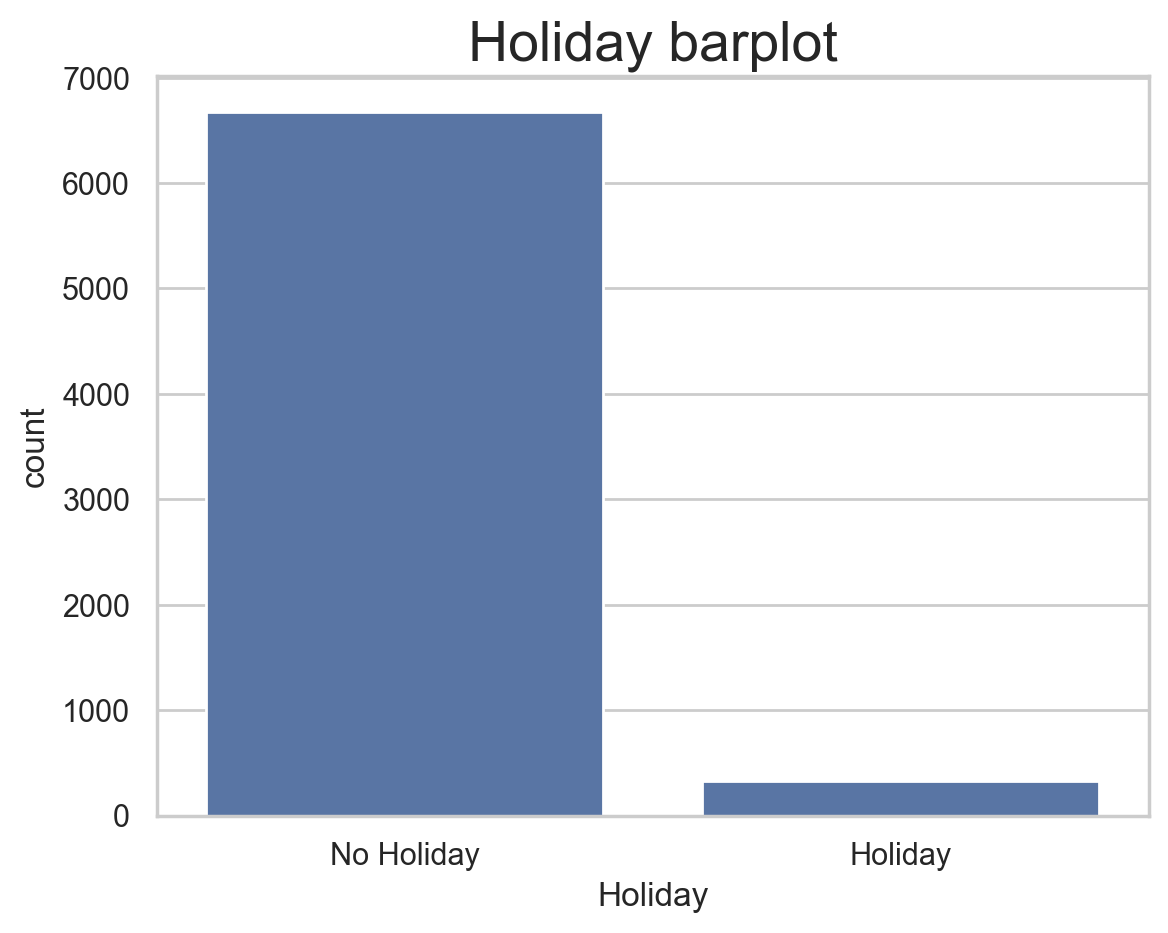

In [43]:
print(df3['Holiday'].value_counts())
#시각화
sns.countplot(x='Holiday',data=df3)
plt.title('Holiday barplot',fontsize=20)
plt.show()

공휴일이 아닌 날이 대부분. 당연한 사실임. 이상치 X

### Functioning Day

Functioning Day
Yes    6772
No      236
Name: count, dtype: int64


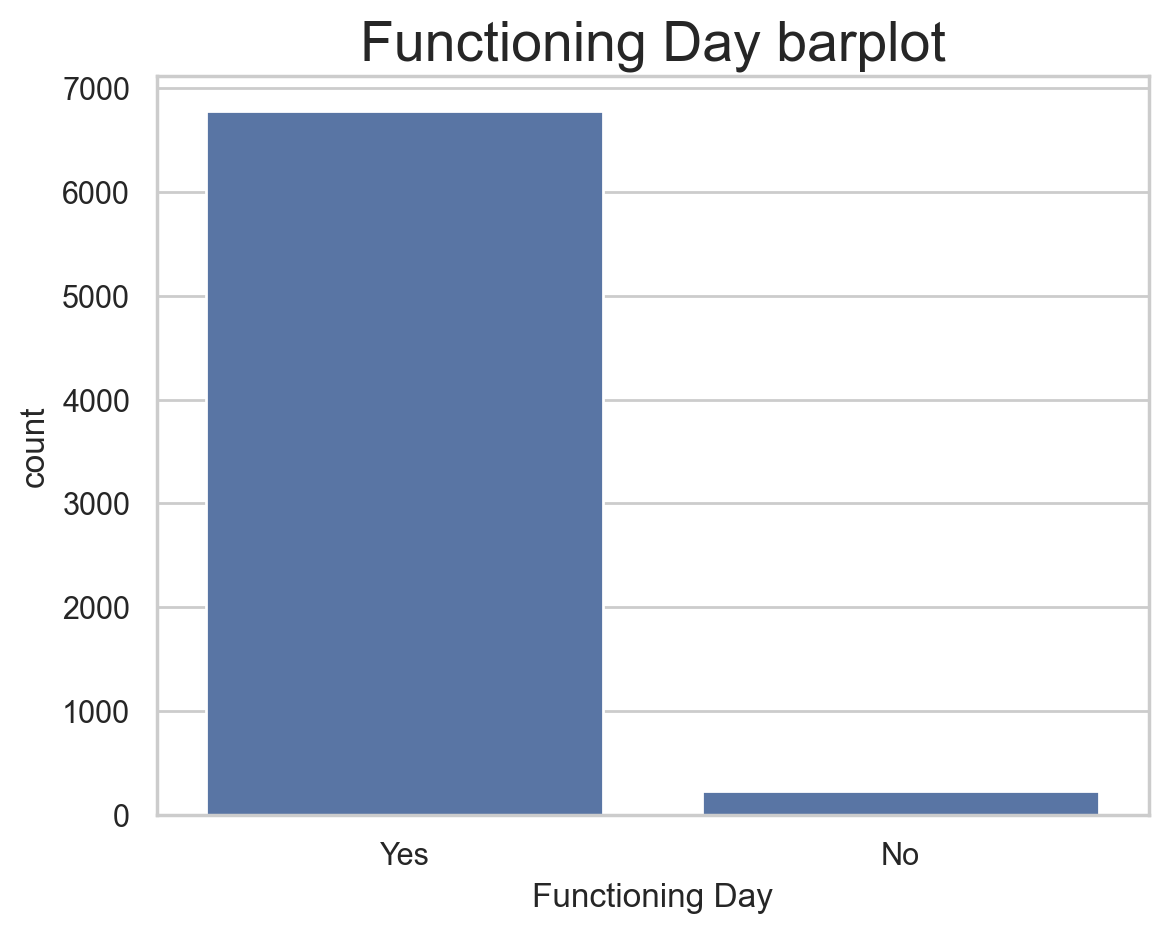

In [45]:
print(df3['Functioning Day'].value_counts())
#시각화
sns.countplot(x='Functioning Day',data=df3)
plt.title('Functioning Day barplot',fontsize=20)
plt.show()

운영하지 않는 날은 매우 적음. 이상치 X

In [49]:
df3.info() #1차 전처리 완료

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7008 entries, 0 to 7007
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       7008 non-null   datetime64[ns]
 1   Rented Bike Count          7008 non-null   int64         
 2   Hour                       7008 non-null   int64         
 3   Temperature(°C)            7008 non-null   float64       
 4   Humidity(%)                7008 non-null   float64       
 5   Wind speed (m/s)           7008 non-null   float64       
 6   Visibility (10m)           7008 non-null   int64         
 7   Dew point temperature(°C)  7008 non-null   float64       
 8   Solar Radiation (MJ/m2)    7008 non-null   float64       
 9   Rainfall(mm)               7008 non-null   float64       
 10  Snowfall (cm)              7008 non-null   float64       
 11  Seasons                    7008 non-null   object        
 12  Holida

In [15]:
df3.to_csv("~/Desktop/train_1.csv",index=False)

CSV파일로 1차 전처리 완료된 데이터 저장

## 1.(2) - 2차 전처리

**변수설명**
- Date : 날짜(년,월,일)
- Rented Bike Count : 자전거 대여량
- Hour : 대여한 시각(0시는 24시)
- Temperature(°C) : 기온
- Humidity(%) : 상대습도
- Wind speed (m/s) : 풍속
- Visibility (10m) : 가시거리
- Dew point temperature(°C) : 이슬점
- Solar Radiation (MJ/m2) : 일사량
- ~ Rainfall(mm) : 강우량 ~
- ~ Snowfall (cm) : 강설량 ~
- Seasons : 계절
- Holiday : 공휴일
- Functioning Day : 운영일
- Rain : 비 유무(내림 : 1, 내리지 않음 : 0)
- Snow : 눈 유무(내림 : 1, 내리지 않음 : 0)

### 범주형 데이터 수치화
- 명목형 변수 : Seasons, Holiday, Functioning Day, Rain, Snow
- 순서형 변수 : X

명목형 변수를 수치화할 때 사용하는 One-Hot Encoding 진행

In [141]:
data=pd.read_csv("train_1.csv")
data

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Rain,Snow
0,2018-10-24,1492,16,16.6,42.0,1.3,1976,5.0,1.22,0.0,0.0,Autumn,No Holiday,Yes,0,0
1,2018-05-01,1536,14,23.0,64.0,2.8,520,15.8,1.59,0.0,0.0,Spring,Holiday,Yes,0,0
2,2018-11-14,327,2,6.2,59.0,0.6,1584,-1.2,0.00,0.0,0.0,Autumn,No Holiday,Yes,0,0
3,2018-08-31,170,4,23.2,83.0,1.6,1102,20.1,0.00,0.0,0.0,Summer,No Holiday,Yes,0,0
4,2018-06-26,45,5,23.7,64.0,0.9,876,16.4,0.00,0.1,0.0,Summer,No Holiday,Yes,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7003,2018-02-08,255,7,-9.6,67.0,1.0,1503,-14.5,0.00,0.0,0.0,Winter,No Holiday,Yes,0,0
7004,2018-03-28,104,4,10.6,77.0,0.9,422,6.7,0.00,0.0,0.0,Spring,No Holiday,Yes,0,0
7005,2018-04-30,569,0,14.7,54.0,1.3,718,5.4,0.00,0.0,0.0,Spring,No Holiday,Yes,0,0
7006,2018-05-29,2234,8,20.5,66.0,1.7,1062,13.9,0.34,0.0,0.0,Spring,No Holiday,Yes,0,0


In [142]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7008 entries, 0 to 7007
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       7008 non-null   object 
 1   Rented Bike Count          7008 non-null   int64  
 2   Hour                       7008 non-null   int64  
 3   Temperature(°C)            7008 non-null   float64
 4   Humidity(%)                7008 non-null   float64
 5   Wind speed (m/s)           7008 non-null   float64
 6   Visibility (10m)           7008 non-null   int64  
 7   Dew point temperature(°C)  7008 non-null   float64
 8   Solar Radiation (MJ/m2)    7008 non-null   float64
 9   Rainfall(mm)               7008 non-null   float64
 10  Snowfall (cm)              7008 non-null   float64
 11  Seasons                    7008 non-null   object 
 12  Holiday                    7008 non-null   object 
 13  Functioning Day            7008 non-null   objec

In [143]:
ohe = OneHotEncoder(drop='first', sparse_output=False)
# drop='first'-> 다중공선성 방지

result_ohe = ohe.fit_transform(data[["Seasons", "Holiday", "Functioning Day"]]) 
result_ohe

array([[0., 0., 0., 1., 1.],
       [1., 0., 0., 0., 1.],
       [0., 0., 0., 1., 1.],
       ...,
       [1., 0., 0., 1., 1.],
       [1., 0., 0., 1., 1.],
       [0., 0., 0., 1., 1.]])

Rain과 Snow는 이미 0과 1로 구성되어 있기 때문에 원핫인코딩 필요 X

In [144]:
ohe.categories_

[array(['Autumn', 'Spring', 'Summer', 'Winter'], dtype=object),
 array(['Holiday', 'No Holiday'], dtype=object),
 array(['No', 'Yes'], dtype=object)]

각 변수들의 학습된 카테고리 확인

In [145]:
#result_ohe을 데이터프레임으로 변환
df_ohe = pd.DataFrame(result_ohe, columns=ohe.get_feature_names_out(["Seasons", "Holiday", "Functioning Day"]))
df_ohe = df_ohe.astype('int')
df_ohe

,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Functioning Day_Yes
0,0,0,0,1,1
1,1,0,0,0,1
2,0,0,0,1,1
3,0,1,0,1,1
4,0,1,0,1,1
...,...,...,...,...,...
7003,0,0,1,1,1
7004,1,0,0,1,1
7005,1,0,0,1,1
7006,1,0,0,1,1


In [146]:
# Date 변수를 Unix 타임스탬프(밀리초)로 변환하여 int형으로 변환
data['Date_int'] = df3['Date'].view('int64') // 10**6

Date 변수를 int형으로 변환

In [147]:
data_v1 = data.copy()

data_v1 = pd.concat([data_v1, df_ohe], axis=1)
data_v1

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Rain,Snow,Date_int,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Functioning Day_Yes
0,2018-10-24,1492,16,16.6,42.0,1.3,1976,5.0,1.22,0.0,0.0,Autumn,No Holiday,Yes,0,0,1540339200000,0,0,0,1,1
1,2018-05-01,1536,14,23.0,64.0,2.8,520,15.8,1.59,0.0,0.0,Spring,Holiday,Yes,0,0,1525132800000,1,0,0,0,1
2,2018-11-14,327,2,6.2,59.0,0.6,1584,-1.2,0.00,0.0,0.0,Autumn,No Holiday,Yes,0,0,1542153600000,0,0,0,1,1
3,2018-08-31,170,4,23.2,83.0,1.6,1102,20.1,0.00,0.0,0.0,Summer,No Holiday,Yes,0,0,1535673600000,0,1,0,1,1
4,2018-06-26,45,5,23.7,64.0,0.9,876,16.4,0.00,0.1,0.0,Summer,No Holiday,Yes,1,0,1529971200000,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7003,2018-02-08,255,7,-9.6,67.0,1.0,1503,-14.5,0.00,0.0,0.0,Winter,No Holiday,Yes,0,0,1518048000000,0,0,1,1,1
7004,2018-03-28,104,4,10.6,77.0,0.9,422,6.7,0.00,0.0,0.0,Spring,No Holiday,Yes,0,0,1522195200000,1,0,0,1,1
7005,2018-04-30,569,0,14.7,54.0,1.3,718,5.4,0.00,0.0,0.0,Spring,No Holiday,Yes,0,0,1525046400000,1,0,0,1,1
7006,2018-05-29,2234,8,20.5,66.0,1.7,1062,13.9,0.34,0.0,0.0,Spring,No Holiday,Yes,0,0,1527552000000,1,0,0,1,1


In [23]:
data_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7008 entries, 0 to 7007
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       7008 non-null   object 
 1   Rented Bike Count          7008 non-null   int64  
 2   Hour                       7008 non-null   int64  
 3   Temperature(°C)            7008 non-null   float64
 4   Humidity(%)                7008 non-null   float64
 5   Wind speed (m/s)           7008 non-null   float64
 6   Visibility (10m)           7008 non-null   int64  
 7   Dew point temperature(°C)  7008 non-null   float64
 8   Solar Radiation (MJ/m2)    7008 non-null   float64
 9   Rainfall(mm)               7008 non-null   float64
 10  Snowfall (cm)              7008 non-null   float64
 11  Seasons                    7008 non-null   object 
 12  Holiday                    7008 non-null   object 
 13  Functioning Day            7008 non-null   objec

In [148]:
#필요없는 열 제거
data_final = data_v1.drop(["Date","Seasons","Rainfall(mm)", "Snowfall (cm)", "Holiday","Functioning Day"], axis=1)
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7008 entries, 0 to 7007
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rented Bike Count          7008 non-null   int64  
 1   Hour                       7008 non-null   int64  
 2   Temperature(°C)            7008 non-null   float64
 3   Humidity(%)                7008 non-null   float64
 4   Wind speed (m/s)           7008 non-null   float64
 5   Visibility (10m)           7008 non-null   int64  
 6   Dew point temperature(°C)  7008 non-null   float64
 7   Solar Radiation (MJ/m2)    7008 non-null   float64
 8   Rain                       7008 non-null   int64  
 9   Snow                       7008 non-null   int64  
 10  Date_int                   7008 non-null   int64  
 11  Seasons_Spring             7008 non-null   int64  
 12  Seasons_Summer             7008 non-null   int64  
 13  Seasons_Winter             7008 non-null   int64

### 1.(3) - test 파일 불러와서 1,2차 전처리 동일하게 진행

In [149]:
test = pd.read_csv('C:/Users/조현서/Desktop/test.csv',encoding='euc-kr')

In [26]:
print(df.shape, test.shape)

(7008, 14) (1752, 13)


## 1.(3) - test 1차 전처리
- train과 동일하게 전처리

In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       1752 non-null   object 
 1   Hour                       1752 non-null   int64  
 2   Temperature(°C)            1578 non-null   float64
 3   Humidity(%)                1752 non-null   int64  
 4   Wind speed (m/s)           1581 non-null   float64
 5   Visibility (10m)           1752 non-null   int64  
 6   Dew point temperature(°C)  1752 non-null   float64
 7   Solar Radiation (MJ/m2)    1752 non-null   float64
 8   Rainfall(mm)               1752 non-null   float64
 9   Snowfall (cm)              1752 non-null   float64
 10  Seasons                    1575 non-null   object 
 11  Holiday                    1752 non-null   object 
 12  Functioning Day            1752 non-null   object 
dtypes: float64(6), int64(3), object(4)
memory usage:

In [150]:
#Date변수 datetime형식으로 변경
test['Date'] = pd.to_datetime(test['Date'], format='%d/%m/%Y')

In [151]:
test.loc[test['Date'].dt.month.between(3, 5) & test['Seasons'].isna(), 'Seasons'] = 'Spring'

test.loc[test['Date'].dt.month.between(6, 8) & test['Seasons'].isna(), 'Seasons'] = 'Summer'

test.loc[test['Date'].dt.month.between(9, 11) & test['Seasons'].isna(), 'Seasons'] = 'Autumn'

test.loc[test['Date'].dt.month.isin([12,1,2]) & test['Seasons'].isna(), 'Seasons'] = 'Winter'

Seasons 결측치 처리

In [152]:
test1=test.copy()

#스플라인 보간법
test1['Wind speed (m/s)'] = test1['Wind speed (m/s)'].interpolate(method='spline', order=3)

Wind speed (m/s) 이상치, 결측치 처리

In [153]:
filtered_test = test1[(test1['Date'] >= '2018-05-21') & (test1['Date'] <= '2018-05-28')] 
#2018년 5월 21일 ~ 28일까지만 필터링

# 21일~ 28일 사이의 Hour 변수가 3에서 7 사이인 데이터들만 필터링하고, Humidity(%) 값이 0이 아닌 데이터만 선택
filtered_hour_test = filtered_test[(filtered_test['Hour'] >= 3) & (filtered_test['Hour'] <= 7) & (filtered_test['Humidity(%)'] != 0)]

# 평균 상대습도 값을 계산
average_h_t = filtered_hour_test['Humidity(%)'].mean()

test2=test1.copy()
# Humidity(%) 값이 0인 데이터에 평균값을 대입
test2.loc[(test2['Humidity(%)'] == 0), 'Humidity(%)'] = average_h_t

Humidity(%) 이상치 처리

In [154]:
test3=test2.copy()

test3['Temperature(°C)'] = test3.apply(
    lambda row: row['Dew point temperature(°C)'] + (100 - row['Humidity(%)']) / 5 
    if pd.isnull(row['Temperature(°C)']) else row['Temperature(°C)'], axis=1
)

Temperature(°C) 결측치 처리

In [155]:
# Rain변수 생성
test3['Rain'] = test3['Rainfall(mm)'].apply(lambda x: 0 if x == 0 else 1)
# Snow 변수 생성
test3['Snow'] = test3['Snowfall (cm)'].apply(lambda x: 0 if x == 0 else 1)

Rrain, Snow 파생변수 생성

## 1.(4) - test 2차 전처리

In [156]:
ohe_t = OneHotEncoder(drop='first', sparse_output=False)
# drop='first'-> 다중공선성 방지

result_ohe_t = ohe_t.fit_transform(test3[["Seasons", "Holiday", "Functioning Day"]]) 
result_ohe_t

array([[0., 1., 0., 1., 1.],
       [0., 0., 0., 1., 1.],
       [1., 0., 0., 1., 1.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 1.],
       [0., 1., 0., 1., 1.]])

명목형 변수 원핫인코딩

In [157]:
#result_ohe_t를 데이터프레임으로 변환
test_ohe = pd.DataFrame(result_ohe_t, columns=ohe_t.get_feature_names_out(["Seasons", "Holiday", "Functioning Day"]))
test_ohe = test_ohe.astype('int')
test_ohe

,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Functioning Day_Yes
0,0,1,0,1,1
1,0,0,0,1,1
2,1,0,0,1,1
3,1,0,0,1,1
4,0,0,0,1,1
...,...,...,...,...,...
1747,1,0,0,1,1
1748,1,0,0,1,1
1749,0,0,0,1,0
1750,0,0,0,1,1


In [158]:
# Date 변수를 Unix 타임스탬프(밀리초)로 변환하여 int형으로 변환
test3['Date_int'] = test3['Date'].view('int64') // 10**6

Date변수 int형으로 변환

In [159]:
test_v1 = test3.copy()

test_v1 = pd.concat([test_v1, test_ohe], axis=1)
test_v1

,Date,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Rain,Snow,Date_int,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Functioning Day_Yes
0,2018-07-11,22,27.1,79.0,1.200000,1578,23.1,0.00,0.0,0.0,Summer,No Holiday,Yes,0,0,1531267200000,0,1,0,1,1
1,2018-11-28,11,5.7,15.0,1.100000,1419,-19.0,0.98,0.0,0.0,Autumn,No Holiday,Yes,0,0,1543363200000,0,0,0,1,1
2,2018-04-18,15,19.0,21.0,3.300000,1716,-3.8,2.88,0.0,0.0,Spring,No Holiday,Yes,0,0,1524009600000,1,0,0,1,1
3,2018-03-09,14,8.0,42.0,1.563110,1690,-4.1,1.24,0.0,0.0,Spring,No Holiday,Yes,0,0,1520553600000,1,0,0,1,1
4,2018-10-28,16,12.2,65.0,1.900000,2000,5.8,0.52,0.0,0.0,Autumn,No Holiday,Yes,0,0,1540684800000,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,2018-05-08,7,15.3,60.0,2.000000,2000,7.5,0.35,0.0,0.0,Spring,No Holiday,Yes,0,0,1525737600000,1,0,0,1,1
1748,2018-03-19,17,8.5,59.0,2.700000,1927,0.9,0.16,0.0,0.0,Spring,No Holiday,Yes,0,0,1521417600000,1,0,0,1,1
1749,2018-10-04,20,21.3,53.0,1.800000,2000,11.3,0.00,0.0,0.0,Autumn,No Holiday,No,0,0,1538611200000,0,0,0,1,0
1750,2018-10-08,12,19.2,31.0,0.500000,1994,1.6,2.40,0.0,0.0,Autumn,No Holiday,Yes,0,0,1538956800000,0,0,0,1,1


In [160]:
#필요없는 열 제거
test_final = test_v1.drop(["Date","Seasons","Rainfall(mm)", "Snowfall (cm)", "Holiday","Functioning Day"], axis=1)
test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Hour                       1752 non-null   int64  
 1   Temperature(°C)            1752 non-null   float64
 2   Humidity(%)                1752 non-null   float64
 3   Wind speed (m/s)           1752 non-null   float64
 4   Visibility (10m)           1752 non-null   int64  
 5   Dew point temperature(°C)  1752 non-null   float64
 6   Solar Radiation (MJ/m2)    1752 non-null   float64
 7   Rain                       1752 non-null   int64  
 8   Snow                       1752 non-null   int64  
 9   Date_int                   1752 non-null   int64  
 10  Seasons_Spring             1752 non-null   int64  
 11  Seasons_Summer             1752 non-null   int64  
 12  Seasons_Winter             1752 non-null   int64  
 13  Holiday_No Holiday         1752 non-null   int64

필요없는 열 제거

### train, valid, test 셋 분리

In [161]:
#X(독립변수), y(종속변수)
X = data_final.drop("Rented Bike Count", axis=1)
y = data_final["Rented Bike Count"]

In [162]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(5606, 15) (1402, 15) (5606,) (1402,)


In [163]:
X_test = test_final.copy()

## 2. 모델 학습 & 선정

- 따릉이 과제는 회귀 문제
- 회귀분석은 종속 변수(목표)와 하나 이상의 독립 변수(예측변수) 간의 미래 사건을 예측하는 방법. 수치적 가치를 추정한다는 측면에서 관측치가 어느 범주에 속하는지를 식별하는 분류 모델과 다르다.
- 회귀분석의 다양한 유형은 아래와 같다.
1. 선형 회귀(Linear regression)
2. SVR(Support Vector Regression)
3. 랜덤 포레스트 회귀 분석(Random Forest Regression)
4. XGBoost(eXtreme Gradient Boosting)

**다른 모델에서의 일관성을 유지하기 위해서 스케일링 방법은 한 개로 통일할 예정**
- 트리 기반 모델들과 달리, 선형 회귀, SVR 등의 모델은 데이터의 크기에 민감하기 때문에, 데이터를 표준화하는 것이 필수
- 데이터에 이상치가 많다면, Robust Scaler를 사용하여 이상치의 영향을 줄이는 것이 좋으나, 이상치 처리는 미리 해놨기 때문에 제외
- 많은 선형 회귀 모델에서 Standard Scaler는 모델의 성능을 안정적으로 유지함.
- But, 따릉이 데이터는 정규 분포를 따르지 않기 때문에, 스케일링 후 데이터의 분포가 비효율적일 수 있음. 또한, 데이터에 음수 값이 없으므로 Min-Max Scaler을 사용

In [164]:
# Min_Max 스케일링
mms = MinMaxScaler()
X_train_mms = mms.fit_transform(X_train)
X_val_mms = mms.transform(X_val)
X_test_mms = mms.transform(X_test)

### 2.(1) - 선형 회귀 (Linear regression)
- 선형 회귀는 종속 변수와 하나 이상의 독립 변수 사이의 선형 관계를 모델링하는 가장 기본적인 회귀 분석 방법. 해당 모델은 특성의 가중치를 계산하여 직선을 통해 데이터를 예측함.

In [53]:
#모델 선언 및 학습
model1 = LinearRegression()
model1.fit(X_train_mms,y_train)

LinearRegression()

In [71]:
# 모델 평가 함수 정의
def model_eval(y_test, y_pred=None):
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    print("\n모델 평가 결과:")
    print("R^2 결정계수: {:.4f}".format(r2))
    print("MSE (Mean Squared Error): {:.4f}".format(mse))
    print("RMSE (Root Mean Squared Error): {:.4f}".format(rmse))
    print("MAE (Mean Absolute Error): {:.4f}".format(mae))

In [55]:
pred = model1.predict(X_val_mms)
model_eval(y_val, pred)


모델 평가 결과:
R^2 결정계수: 0.5852
MSE (Mean Squared Error): 180197.2067
RMSE (Root Mean Squared Error): 424.4964
MAE (Mean Absolute Error): 315.9249


### 2.(2) - SVR(Support Vector Regression)
- SVR은 SVM을 회귀 문제에 적용한 모델.
- 비선형 커널을 사용하면 복잡한 데이터 패턴을 학습할 수 있음

In [51]:
# 모델 선언 및 학습
# SVR의 하이퍼파라미터: C(규제 파라미터), epsilon(마진 허용 범위), kernel(커널 함수)
model2 = SVR(kernel='rbf', C=1.0, epsilon=0.2, gamma='scale')

model2.fit(X_train_mms, y_train.ravel())  # y_train.ravel()로 1차원 배열로 변환

SVR(epsilon=0.2)

In [56]:
pred2 = model2.predict(X_val_mms)
model_eval(y_val, pred2)


모델 평가 결과:
R^2 결정계수: 0.2991
MSE (Mean Squared Error): 304454.9896
RMSE (Root Mean Squared Error): 551.7744
MAE (Mean Absolute Error): 374.8456


### 2.(3) - 랜덤 포레스트 회귀 분석(Random Forest Regression)
- 다수의 결정 트리를 생성하고, 이들의 예측을 평균하여 최종 결과를 도출하는 앙상블 학습 방법
- 여러 결정 트리를 결합해 과적합을 줄이고, 예측 성능을 향상시킴
- 각 특성이 예측에 미치는 중요도를 평가할 수 있어, 특성 선택 및 해석에 유용
- 많은 트리를 사용하기 때문에 모델이 복잡하고, 메모리 사용량과 계산 비용이 높음

In [64]:
#모델 선언
model3 = RandomForestClassifier(random_state=42)

In [65]:
print(model3.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [66]:
#학습
model3.fit(X_train_mms, y_train)

RandomForestClassifier(random_state=42)

In [67]:
#평가
pred3 = model3.predict(X_val_mms)
model_eval(y_val, pred3)


모델 평가 결과:
R^2 결정계수: 0.7653
MSE (Mean Squared Error): 101927.1619
RMSE (Root Mean Squared Error): 319.2603
MAE (Mean Absolute Error): 187.3017


### 2.(4) - XGBoost(eXtreme Gradient Boosting)
- 결정 트리를 기반으로 하는 강력한 앙상블 학습 알고리즘
- 병렬처리와 분산 학습으로 빠르게 학습 가능
- 다양한 하이퍼파라미터를 조정해 과적합 방지
- 많은 하이퍼파라미터가 존재해, 최적화하기 위해 상당한 시간이 소요

In [92]:
# 모델 선언
model4 = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)


In [93]:
# 학습
model4.fit(X_train_mms, y_train.ravel())  # y_train.ravel()로 1차원 배열로 변환

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [94]:
pred4 = model4.predict(X_val_mms)
model_eval(y_val, pred4)


모델 평가 결과:
R^2 결정계수: 0.9049
MSE (Mean Squared Error): 41326.9495
RMSE (Root Mean Squared Error): 203.2903
MAE (Mean Absolute Error): 130.4574


XGBoost가 가장 높은 R^2값(0.9049)값과 가장 낮은 MSE, RMSE, MAE값을 기록했음. 
- R^2 = 데이터의 변동성을 가장 잘 설명
- MSE =예측 오류가 가장 적음
- RMSE = 평균 예측 오차가 가장 적음
- MAE = 평균 절대 오차가 가장 적음

**따라서 높은 예측도와 낮은 예측 오류를 제공하는 XGBoost 모델로 성능 개선을 진행하기로 결정**

## 3. 하이퍼파라미터 튜닝
- n_estimators : 총 결정 트리의 개수
- learning_rate : 각 트리가 기여하는 학습 속도
- max_depth : 각 결정 트리의 최대 깊이. 복잡성을 조절
- min_child_weight : 리프 노드에서의 최소 가중치 합. 과적합을 줄이는 데 도움
- subsample : 각 트리가 학습할 때 사용하는 데이터 샘플의 비율.
- colsample_bytree : 각 트리를 만들 때 사용할 특성의 비율

### 3.(1) - GridSearchCV

In [89]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
# 하이퍼파라미터 범위 정의
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_child_weight': [1, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [90]:
gs = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3)

In [91]:
# 하이퍼파라미터 튜닝 수행
gs.fit(X_train_mms, y_train.ravel())

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'min_child_weight': [1, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})

In [95]:
#최적의 하이퍼파라미터
gs.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 5,
 'n_estimators': 200,
 'subsample': 0.8}

In [96]:
#최고의 교차 검증 점수(R^2)
gs.best_score_

np.float64(0.8840466737747192)

In [97]:
# GridSearch 결과를 데이터 프레임으로 저장
# 어떤 경우에 높은 성능이 나오는지 확인 가능
gs_result = pd.DataFrame(gs.cv_results_)
gs_result.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
30,0.733040,0.120098,0.018616,0.001244,0.8,0.10,5,5,200,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.888523,0.883639,0.879978,0.884047,0.003500,1
26,0.380317,0.021627,0.008976,0.000814,0.8,0.10,5,1,200,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.883971,0.883793,0.881642,0.883135,0.001058,2
31,0.526259,0.033816,0.015295,0.005238,0.8,0.10,5,5,200,1.0,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.885137,0.883449,0.880388,0.882991,0.001965,3
63,0.354717,0.004908,0.010307,0.002049,1.0,0.10,5,5,200,1.0,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.885867,0.884383,0.878251,0.882834,0.003297,4
59,0.365193,0.002088,0.008312,0.000470,1.0,0.10,5,1,200,1.0,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.885769,0.880489,0.881773,0.882677,0.002249,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.138296,0.027182,0.006649,0.000470,0.8,0.01,3,1,100,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.550266,0.538631,0.541223,0.543373,0.004987,60
5,0.186165,0.011867,0.007316,0.001884,0.8,0.01,3,5,100,1.0,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.550335,0.537170,0.539718,0.542408,0.005701,61
1,0.140620,0.032290,0.007314,0.001244,0.8,0.01,3,1,100,1.0,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.550335,0.537170,0.539702,0.542402,0.005704,62
33,0.184174,0.026592,0.009640,0.005235,1.0,0.01,3,1,100,1.0,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.553192,0.534139,0.535465,0.540932,0.008686,63


In [98]:
good_model = gs.best_estimator_

In [99]:
good_model.fit(X_train_mms, y_train.ravel())
pred_1 = good_model.predict(X_val_mms)
model_eval(y_val, pred_1)


모델 평가 결과:
R^2 결정계수: 0.9098
MSE (Mean Squared Error): 39182.4760
RMSE (Root Mean Squared Error): 197.9456
MAE (Mean Absolute Error): 130.1408


**기본 모델 평가 결과:**
- R^2 결정계수: 0.9049
- MSE (Mean Squared Error): 41326.9495
- RMSE (Root Mean Squared Error): 203.2903
- MAE (Mean Absolute Error): 130.4574

### => GridSearch로 파라미터 튜닝한 모델 평가 결과:
- R^2 결정계수: 0.9098
- MSE (Mean Squared Error): 39182.4760
- RMSE (Root Mean Squared Error): 197.9456
- MAE (Mean Absolute Error): 130.1408

### 3.(2) - RandomizedSearchCV
- 하이퍼파라미터 공간에서 무작위로 샘플링해 최적의 하이퍼파라미터를 찾는 방법

In [100]:
# 모델 선언
rs_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# 하이퍼파라미터 범위 정의
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [103]:
rs = RandomizedSearchCV(estimator=rs_model,
                                   param_distributions=param_dist,
                                   n_iter=50,  # 시도할 하이퍼파라미터 조합의 수
                                   scoring='r2',  # R^2 점수를 사용하여 평가
                                   cv=3,  # 교차 검증의 fold 수
                                   verbose=2,  # 출력 레벨
                                   random_state=42,  # 재현성을 위한 random_state 설정
                                   ) 

In [104]:
# RandomizedSearchCV를 사용한 하이퍼파라미터 튜닝
rs.fit(X_train_mms, y_train.ravel())

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total tim

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=50,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [100, 200, 300, 400],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='r2', verbose=2)

In [105]:
# 최적의 하이퍼파라미터
rs.best_params_

{'subsample': 0.8,
 'n_estimators': 400,
 'min_child_weight': 3,
 'max_depth': 5,
 'learning_rate': 0.1,
 'colsample_bytree': 0.8}

In [106]:
#최고의 교차 검증 R^2 점수
rs.best_score_

np.float64(0.8848389983177185)

In [107]:
good_model2 = rs.best_estimator_

In [108]:
good_model2.fit(X_train_mms, y_train.ravel())
pred_2 = good_model2.predict(X_val_mms)
model_eval(y_val, pred_2)


모델 평가 결과:
R^2 결정계수: 0.9144
MSE (Mean Squared Error): 37189.1287
RMSE (Root Mean Squared Error): 192.8448
MAE (Mean Absolute Error): 124.6238


**기본 모델 평가 결과:**
- R^2 결정계수: 0.9049
- MSE (Mean Squared Error): 41326.9495
- RMSE (Root Mean Squared Error): 203.2903
- MAE (Mean Absolute Error): 130.4574

### => RandomizedSearch로 파라미터 튜닝한 모델 평가 결과:
- R^2 결정계수: 0.9144
- MSE (Mean Squared Error): 37189.1287
- RMSE (Root Mean Squared Error): 192.8448
- MAE (Mean Absolute Error): 124.623

## 4. 최종 모델과 하이퍼파라미터, 변수 선택
- 기본 모델 학습 결과 XGBoost 모델로 선정
- 하이퍼파라미터 튜닝 결과 RandomizedSearch 방법 이용
- 변수 중요도를 참고해 변수 선택

**RandomizedSearch로 파라미터 튜닝한 모델 평가 결과:**
- R^2 결정계수: 0.9144
- MSE (Mean Squared Error): 37189.1287
- RMSE (Root Mean Squared Error): 192.8448
- MAE (Mean Absolute Error): 124.623

### 변수 중요도 확인

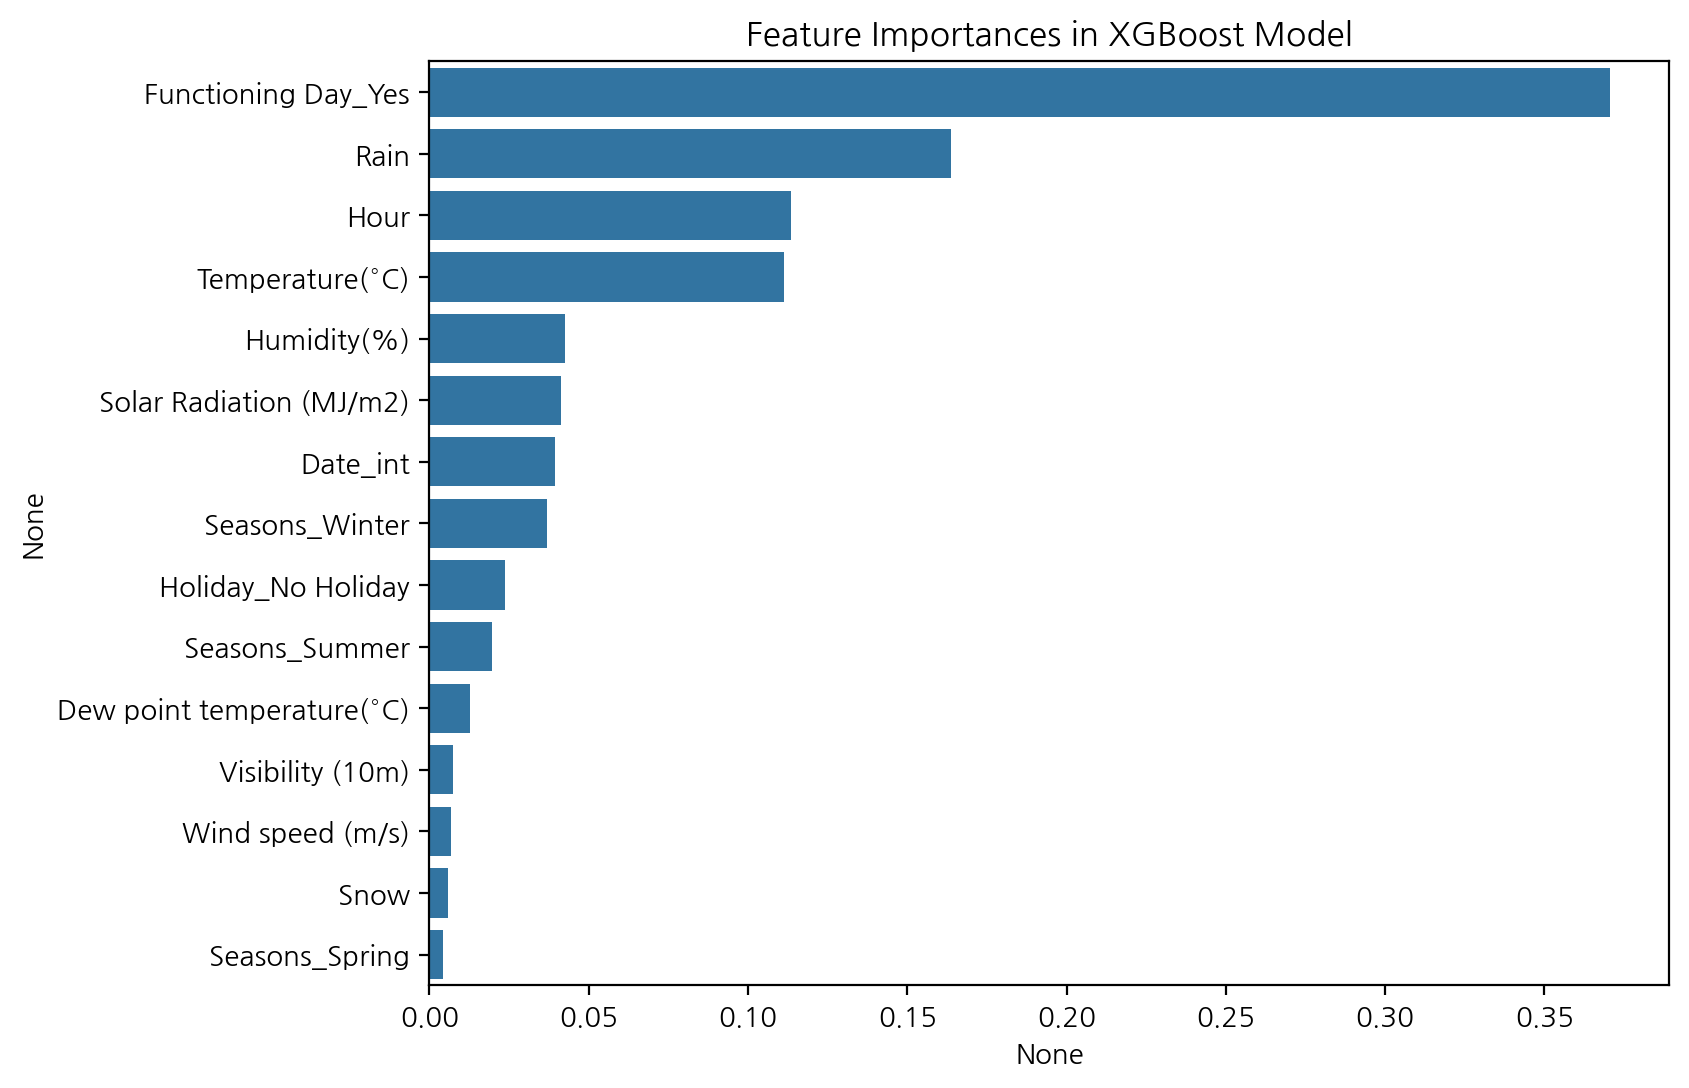

In [114]:
# X_train_mms를 DataFrame으로 변환
X_train_df = pd.DataFrame(X_train_mms, columns=['Hour','Temperature(°C)','Humidity(%)','Wind speed (m/s)','Visibility (10m)','Dew point temperature(°C)','Solar Radiation (MJ/m2)','Rain','Snow','Date_int','Seasons_Spring','Seasons_Summer','Seasons_Winter','Holiday_No Holiday','Functioning Day_Yes'])

# XGBoost 모델 학습 후 변수 중요도 계산
importances_values = pd.Series(rs.best_estimator_.feature_importances_, index=X_train_df.columns).sort_values(ascending=False)

# 변수 중요도 시각화
plt.figure(figsize=(8, 6))
plt.title('Feature Importances in XGBoost Model')
sns.barplot(x=importances_values, y=importances_values.index)
plt.show()

- Functioning Day_Yes, Rain, Hour, Temperature 순으로 변수 중요도가 높게 나옴
- Functioning Day_Yes의 경우는 운영을 하는 날이므로 당연히 종속변수인 Rendted Bike Count에 대한 중요도가 높음. 따라서 배제 가능
- Functioning Day를 제외하고 보면 비와, 시간대, 온도가 종속 변수에 대한 중요도가 높음
- 의외로 Rain과 Snow는 변수 중요도 차이가 많이 남 
- 온도 변수가 중요한 것을 보니, 폭염보다 한파가 왔을 때 자전거 대여량이 현저하게 줄어든 점을 발견했던 사실도 떠오름
- 비의 여부, 출근과 퇴근시간대, 온도에 따른 자전거 대여량을 예측하고, 몇 대의 자전거를 비치하는 것이 가장 효율적일지 생각해 볼 수 있음

위와 같은 이유로 'Functioning Day_Yes'변수를 제외하기로 최종 결정

In [166]:
# train셋 Functioning Day_Yes 변수 제거
data_final2 = data_final.drop(["Functioning Day_Yes"], axis=1)
data_final2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7008 entries, 0 to 7007
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rented Bike Count          7008 non-null   int64  
 1   Hour                       7008 non-null   int64  
 2   Temperature(°C)            7008 non-null   float64
 3   Humidity(%)                7008 non-null   float64
 4   Wind speed (m/s)           7008 non-null   float64
 5   Visibility (10m)           7008 non-null   int64  
 6   Dew point temperature(°C)  7008 non-null   float64
 7   Solar Radiation (MJ/m2)    7008 non-null   float64
 8   Rain                       7008 non-null   int64  
 9   Snow                       7008 non-null   int64  
 10  Date_int                   7008 non-null   int64  
 11  Seasons_Spring             7008 non-null   int64  
 12  Seasons_Summer             7008 non-null   int64  
 13  Seasons_Winter             7008 non-null   int64

In [167]:
#test셋도 동일하게 설정
test_final2 = test_final.drop(["Functioning Day_Yes"], axis=1)
test_final2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Hour                       1752 non-null   int64  
 1   Temperature(°C)            1752 non-null   float64
 2   Humidity(%)                1752 non-null   float64
 3   Wind speed (m/s)           1752 non-null   float64
 4   Visibility (10m)           1752 non-null   int64  
 5   Dew point temperature(°C)  1752 non-null   float64
 6   Solar Radiation (MJ/m2)    1752 non-null   float64
 7   Rain                       1752 non-null   int64  
 8   Snow                       1752 non-null   int64  
 9   Date_int                   1752 non-null   int64  
 10  Seasons_Spring             1752 non-null   int64  
 11  Seasons_Summer             1752 non-null   int64  
 12  Seasons_Winter             1752 non-null   int64  
 13  Holiday_No Holiday         1752 non-null   int64

In [168]:
X_test=test_final2.copy()

In [169]:
#X(독립변수), y(종속변수)
X = data_final2.drop("Rented Bike Count", axis=1)
y = data_final2["Rented Bike Count"]

In [171]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(5606, 14) (1402, 14) (5606,) (1402,)


## 5. 최종모델 예측 - test셋에 대해

In [172]:
# Min_Max 스케일링
mms = MinMaxScaler()
X_train_mms = mms.fit_transform(X_train)
X_val_mms = mms.transform(X_val)
X_test_mms = mms.transform(X_test)

In [173]:
# 모델 선언
rs_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# 하이퍼파라미터 범위 정의
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [174]:
rs = RandomizedSearchCV(estimator=rs_model,
                                   param_distributions=param_dist,
                                   n_iter=50,  # 시도할 하이퍼파라미터 조합의 수
                                   scoring='r2',  # R^2 점수를 사용하여 평가
                                   cv=3,  # 교차 검증의 fold 수
                                   verbose=2,  # 출력 레벨
                                   random_state=42,  # 재현성을 위한 random_state 설정
                                   ) 

In [175]:
# RandomizedSearchCV를 사용한 하이퍼파라미터 튜닝
rs.fit(X_train_mms, y_train.ravel())

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.6; total tim

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=50,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [100, 200, 300, 400],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='r2', verbose=2)

In [176]:
# 모델 선언
final_model = rs.best_estimator_

# 모델 학습
final_model.fit(X_train_mms, y_train.ravel())

# test 데이터로 예측
test_final2['Rented Bike Count'] = 0
test_final2['Rented Bike Count'] = final_model.predict(X_test_mms)

In [179]:
test_final2

,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rain,Snow,Date_int,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Rented Bike Count
0,22,27.1,79.0,1.200000,1578,23.1,0.00,0,0,1531267200000,0,1,0,1,1803.999390
1,11,5.7,15.0,1.100000,1419,-19.0,0.98,0,0,1543363200000,0,0,0,1,694.136169
2,15,19.0,21.0,3.300000,1716,-3.8,2.88,0,0,1524009600000,1,0,0,1,981.729858
3,14,8.0,42.0,1.563110,1690,-4.1,1.24,0,0,1520553600000,1,0,0,1,723.884888
4,16,12.2,65.0,1.900000,2000,5.8,0.52,0,0,1540684800000,0,0,0,1,855.702637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,7,15.3,60.0,2.000000,2000,7.5,0.35,0,0,1525737600000,1,0,0,1,1112.712402
1748,17,8.5,59.0,2.700000,1927,0.9,0.16,0,0,1521417600000,1,0,0,1,561.858337
1749,20,21.3,53.0,1.800000,2000,11.3,0.00,0,0,1538611200000,0,0,0,1,630.063049
1750,12,19.2,31.0,0.500000,1994,1.6,2.40,0,0,1538956800000,0,0,0,1,1413.962769


In [180]:
test_final2.to_csv('test_예측완료.csv', index = False)

test셋 예측 후 csv로 저장 완료